##### Disclaimer: this notebook is not complete yet

The goal of this project is to create a model for real-time traffic light detection. The dataset used for this project is BDD100k,  however, the annotations and the whole dataset strcture was taken from https://datasetninja.com/bdd100k.

This notebook covers analysis and preperation of the dataset for the training process and shows the results of it.

For the training we are using the state-of-the-art Ultralytics YOLOv8 CV model and the sample version of the dataset with some changes to it.

The whole process will be done in the follwing steps:
1. Load the json files and generate a dataframe from it
2. Review the dataframe
3. Count the objects and store results to another dataframe
4. Generate labels for the YOLO format
5. Train the model - this, I cant do localy so its not in the notebook (this is either done on an EC2 machine or Google Colab)
6. Review the results (confusion matrix, performance metrics and a couple of test examples)
7. If we are not satisfied with the results, increase the amount of pictures with traffic lights by taking the pictures and annotations from the complete 100k dataset and/or reduce the amount of background pictures and repeat the process from step 4

#### Step 1 - Loading the json files and generating a dataframe

In [7]:
import numpy as np
import pandas as pd
import json
import os
import itertools
from tqdm import tqdm

In [13]:
def load_annotations(annotations_folder_path):
    annotations = []
    for annotation_name in tqdm(os.listdir(annotations_folder_path)):
        annotation_path = os.path.join(annotations_folder_path, annotation_name)
        annotation = json.load(open(annotation_path))
        annotation["filename"] = annotation_name.replace(".json", "")
        annotations.append(annotation)
    return annotations

In [14]:
def get_flattened_dict(input_dict, base_key="", output_dict={}, index_value=None):
    
    for key in input_dict.keys():
        
        if base_key == "":
            full_key = key     
        else:
            if index_value is None:
                full_key = base_key + "/" + key
            else:
                full_key = base_key + "/" + key + "/" + index_value

        if isinstance(input_dict[key], dict):
            get_flattened_dict(input_dict[key], full_key, output_dict)
            
        elif isinstance(input_dict[key], list):
            for index, item in enumerate(input_dict[key]):
                full_list_key = full_key
                get_flattened_dict(item, full_list_key, output_dict, str(index))
                    
        else:
            output_dict[full_key] = input_dict[key]

In [15]:
KEY_ORDER_DICT = {
    "description": "00-00000-00",
    "tags":[],
    "size": {
        "width": "02-0000-00",
        "height": "03-0000-00"
    },
    "objects": []
}

In [16]:
def get_column_index(split_key, key_order_dict, level=0, id_value=None):
    key = split_key[level]
   
        
    if isinstance(key_order_dict[key], dict):
        return get_column_index(split_key, key_order_dict[key], level+1, id_value)
    
    else:
        column_index = key_order_dict[key]
        if id_value is not None:
            split_column_index = column_index.split("-")
            split_column_index[1] = split_column_index[1].replace("id", id_value)[-5:]
            column_index = "-".join(split_column_index)
        return column_index

In [17]:


def get_sorted_columns(annotation_df_columns):
    sorted_annotation_df_cols = []
    for annotation_df_col in annotation_df_columns:
        split_col = annotation_df_col.split("/")
        col_index = get_column_index(split_col, KEY_ORDER_DICT, 0)
        sorted_annotation_df_cols.append(str(col_index) + "#" + annotation_df_col)
    sorted_annotation_df_cols.sort()
    sorted_annotation_df_cols = [sorted_annotation_df_col.split("#")[1] for sorted_annotation_df_col in sorted_annotation_df_cols]
    return sorted_annotation_df_cols



In [18]:
def get_annotation_df(annotations):
    annotation_dicts = []
    for annotation in annotations:
        annotation_dict = {}
        get_flattened_dict(annotation, "", annotation_dict)
        annotation_dicts.append(annotation_dict)
    annotation_dicts_keys = set(list(itertools.chain.from_iterable([list(annotation_dict.keys()) for annotation_dict in annotation_dicts])))
    annotation_dicts_keys = get_sorted_columns(list(annotation_dicts_keys))
    annotation_df_dict = {key: [] for key in annotation_dicts_keys}
    for annotation_dict in annotation_dicts:
        for key in annotation_df_dict:
            value = annotation_dict[key] if key in annotation_dict else np.nan
            annotation_df_dict[key].append(value)
    json_df = pd.DataFrame(annotation_df_dict)
    return json_df

In [8]:
train_annotations_path = "bdd100ksample1/train/ann"
train_annotations = load_annotations(train_annotations_path)



df_train = pd.DataFrame.from_dict(train_annotations, orient='columns')

val_annotations_path = "bdd100ksample1/val/ann"
val_annotations = load_annotations(val_annotations_path)



df_val = pd.DataFrame.from_dict(val_annotations, orient='columns')


100%|███████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 605.32it/s]


#### Step 2 - review tha dataframe 

In [9]:
df_train

,description,tags,size,objects,filename
0,,"[{'id': 10819984, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89269710, 'classId': 6508800, 'descrip...",002d290d-89f4e5c0.jpg
1,,"[{'id': 10820548, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89274776, 'classId': 6508800, 'descrip...",00abd8a7-ecd6fc56.jpg
2,,"[{'id': 10820801, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89277885, 'classId': 6508804, 'descrip...",00e100a8-9c852617.jpg
3,,"[{'id': 10821063, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89280517, 'classId': 6508804, 'descrip...",0111523e-a2170455.jpg
4,,"[{'id': 10821078, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89280652, 'classId': 6508800, 'descrip...",0124dfa6-30a430dc.jpg
...,...,...,...,...,...
694,,"[{'id': 11032412, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91633655, 'classId': 6508807, 'descrip...",b0fa25cd-abf2ad39.jpg
695,,"[{'id': 11032637, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91635851, 'classId': 6508807, 'descrip...",b112e05e-bfe04219.jpg
696,,"[{'id': 11032718, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91636637, 'classId': 6508807, 'descrip...",b11d3a0d-e3c248c9.jpg
697,,"[{'id': 11032829, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91637590, 'classId': 6508804, 'descrip...",b127cbe6-ab165ae9.jpg


In [10]:
df_val

,description,tags,size,objects,filename
0,,"[{'id': 10789675, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88945149, 'classId': 6508807, 'descrip...",b1f6c103-8b75ea3e.jpg
1,,"[{'id': 10790092, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88948965, 'classId': 6508804, 'descrip...",b25fb716-78d8d49b.jpg
2,,"[{'id': 10790221, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88950127, 'classId': 6508807, 'descrip...",b26f9b1e-3e172ced.jpg
3,,"[{'id': 10790369, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88952159, 'classId': 6508807, 'descrip...",b289f2e8-cec8700d.jpg
4,,"[{'id': 10791039, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88959006, 'classId': 6508807, 'descrip...",b313a4dc-217f1233.jpg
...,...,...,...,...,...
104,,"[{'id': 10818874, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89256297, 'classId': 6508804, 'descrip...",c9b9fef4-a58bf3d5.jpg
105,,"[{'id': 10818931, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89256888, 'classId': 6508800, 'descrip...",c9c31e57-45b42452.jpg
106,,"[{'id': 10819441, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89261734, 'classId': 6508807, 'descrip...",ca28f275-03f8cef5.jpg
107,,"[{'id': 10819429, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89261594, 'classId': 6508807, 'descrip...",ca28f275-cac4f254.jpg


#### Step 3 - object counting and generating two more dataframes (total amount of objects and how many pictures have x object)

In [11]:
objetcs_id_dict = {
    0: 'car',
    1: 'bus',
    2: 'drivable area',
    3: 'lane',
    4: 'traffic sign',
    5: 'truck',
    6: 'person',
    7: 'traffic light',
    8: 'rider',
    9: 'bike',
    10:'motor',
    11:'train'
}

In [12]:
df_totals_train = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})
df_per_picture_train = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})

df_totals_val = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})
df_per_picture_val = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})


        

In [13]:
for i in range(len(df_train.index)): 
    picture_flags = [False, False, False, False, False, False, False, False, False, False, False, False]
    for o in df_train.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        df_totals_train.loc[0,objetcs_id_dict[o_id]] = df_totals_train.loc[0,objetcs_id_dict[o_id]] + 1
        if not picture_flags[o_id]:
            df_per_picture_train.loc[0,objetcs_id_dict[o_id]] = df_per_picture_train.loc[0,objetcs_id_dict[o_id]] + 1
            picture_flags[o_id] = True

In [14]:
df_totals_train

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,6953,136,1220,5569,2668,342,1088,2178,60,95,42,13


In [15]:
df_per_picture_train

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,692,105,665,676,594,223,265,435,51,51,39,11


In [16]:
for i in range(len(df_val.index)): 
    picture_flags = [False, False, False, False, False, False, False, False, False, False, False, False]
    for o in df_val.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        df_totals_val.loc[0,objetcs_id_dict[o_id]] = df_totals_val.loc[0,objetcs_id_dict[o_id]] + 1
        if not picture_flags[o_id]:
            df_per_picture_val.loc[0,objetcs_id_dict[o_id]] = df_per_picture_val.loc[0,objetcs_id_dict[o_id]] + 1
            picture_flags[o_id] = True

In [17]:
df_totals_val

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,1257,12,202,885,426,55,169,336,8,13,15,0


In [18]:
df_per_picture_val

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,109,11,107,105,97,37,44,74,7,10,4,0


#### Step 4 - Generating the labels in YOLO format

Since this model is supposed to be detecting traffic lights only, we will exclude all other objects in annotations.

In [19]:
for i in range(len(df_train.index)):
    save_location = "bdd100ksample1/train/labels/" + df_train.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df_train.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()

In [20]:
for i in range(len(df_val.index)):
    save_location = "bdd100ksample1/val/labels/" + df_val.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df_val.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()

#### Step 5 - Train the model (this is done externaly)

This first training was an experimental one, it was done locally and was running for around 24 hours.
All of the trining parameters were set to default, except for batch (which was set to 2) and imgsz (which was set to the size of these images since default is 640)

#### Step 6 - review the results

Confusion matrix and results from first training

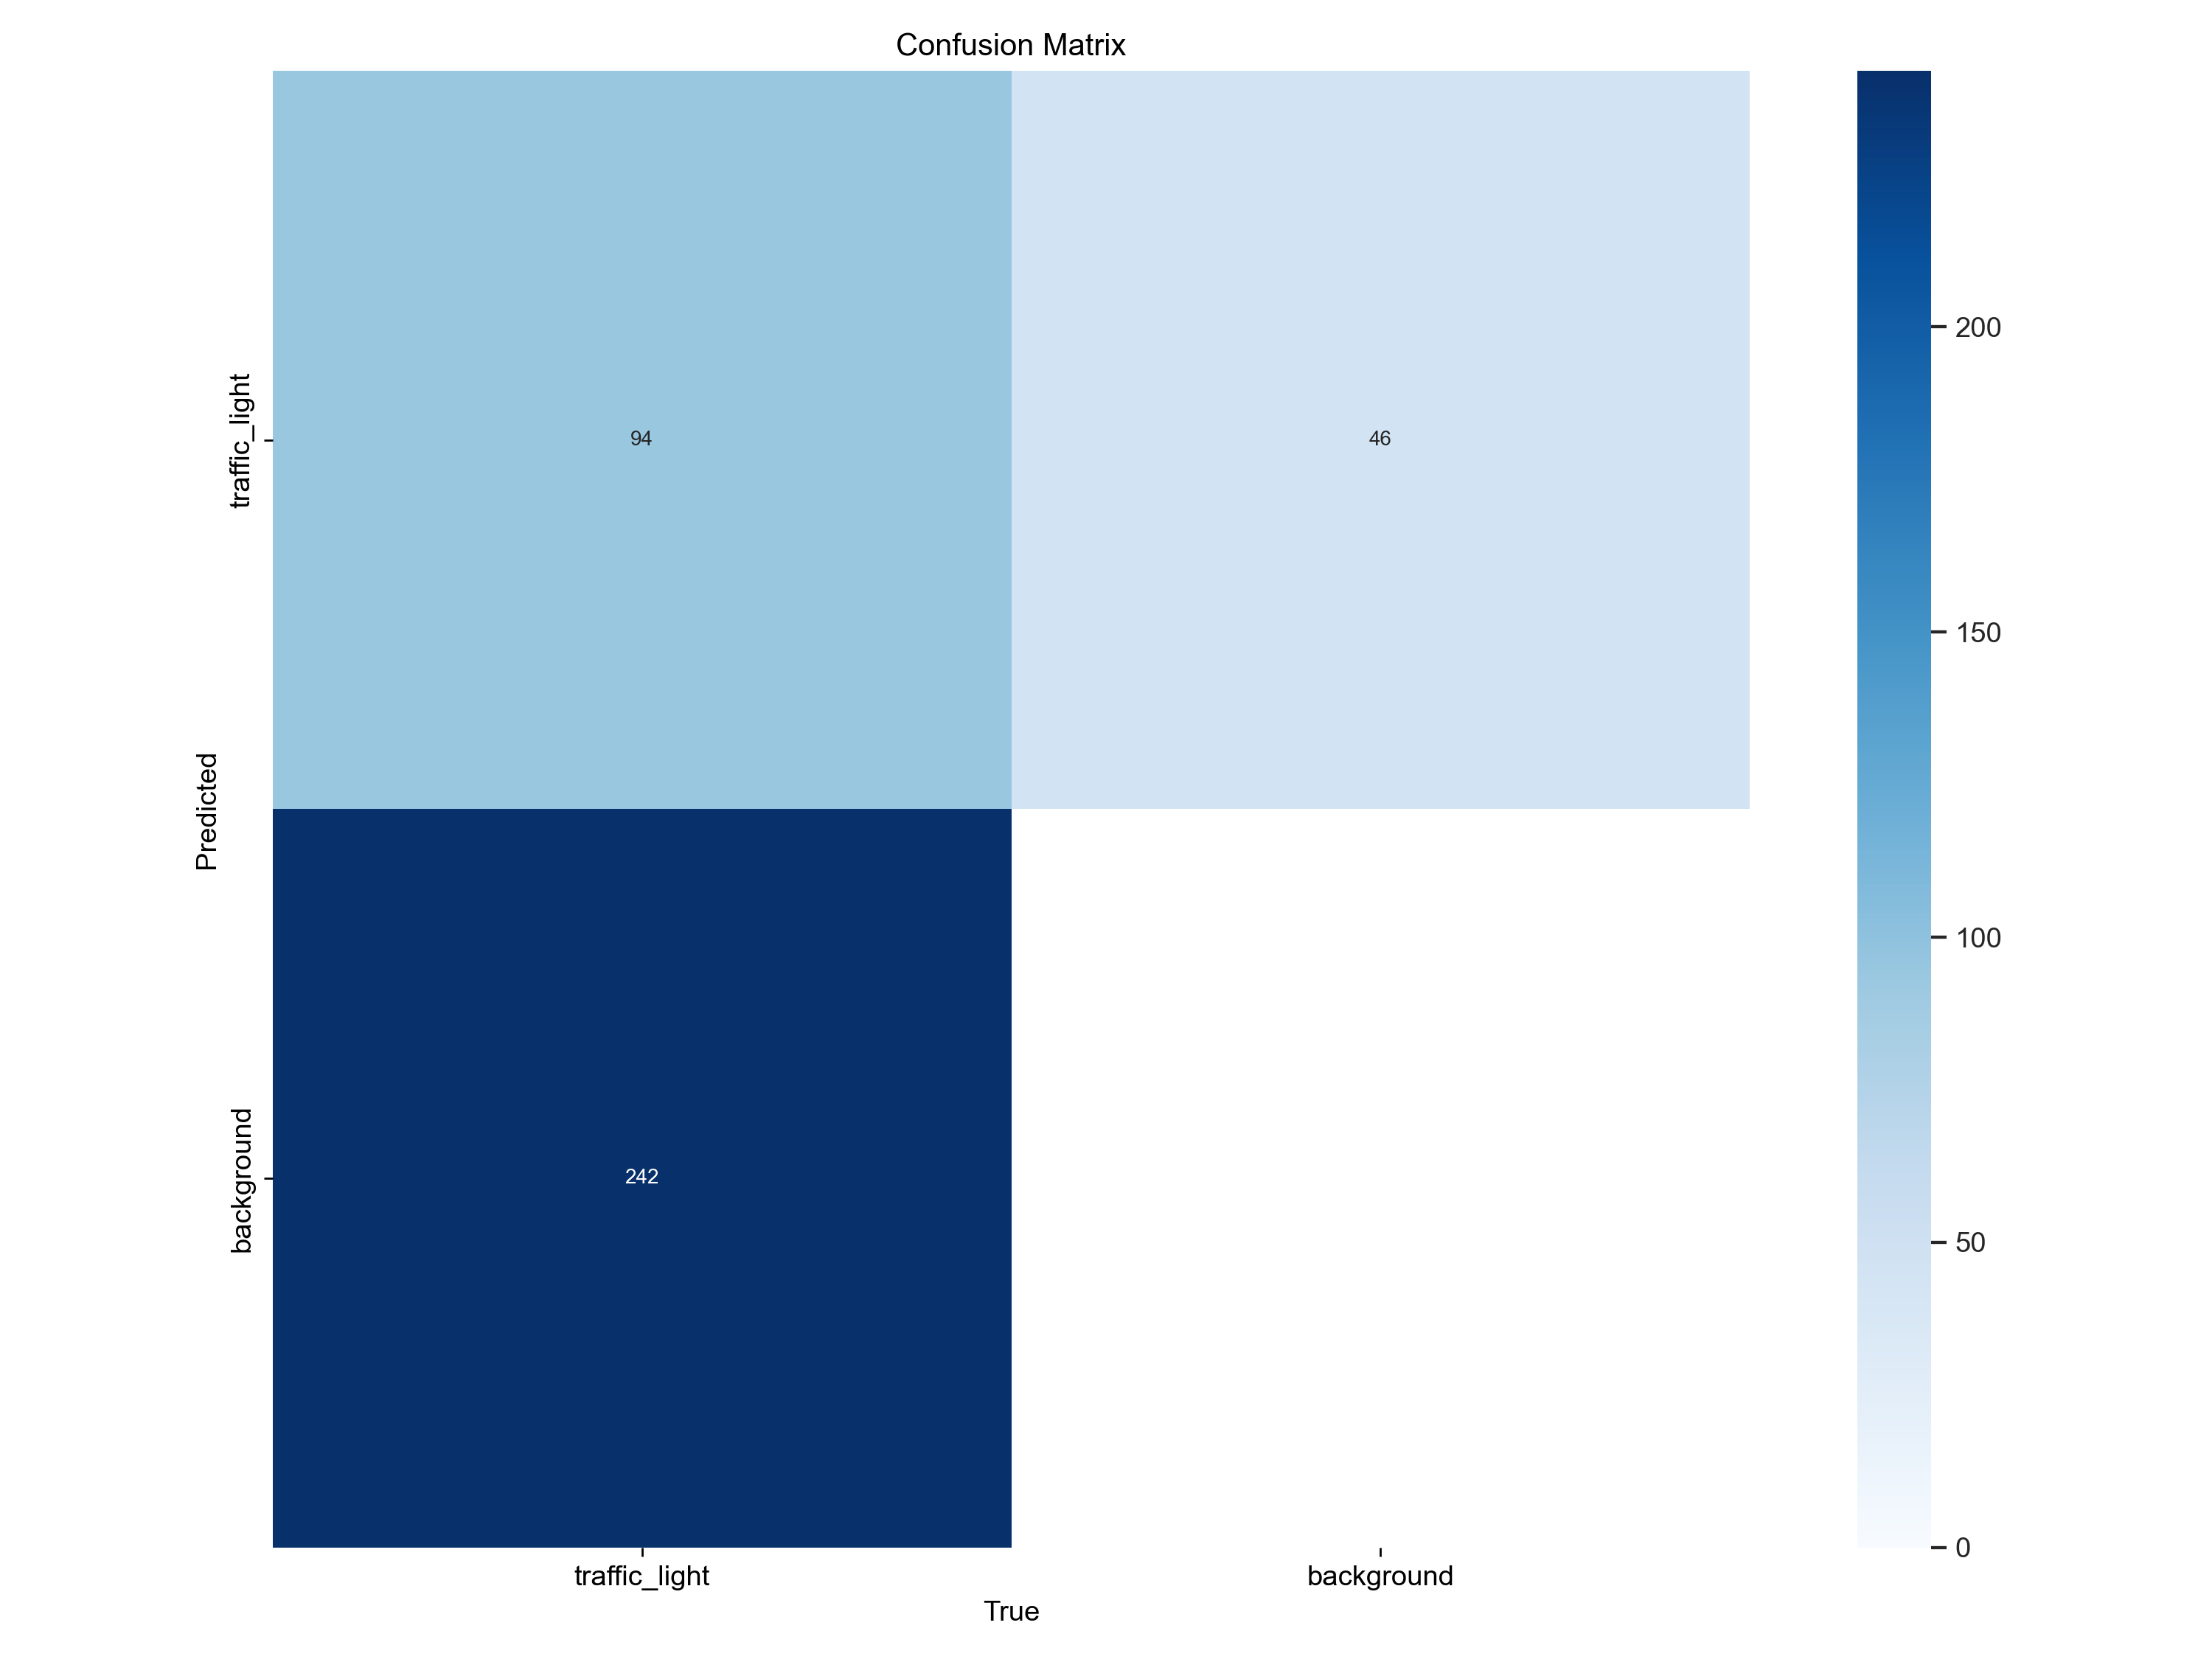

In [1]:
from IPython import display


display.Image('stats/model-1/confusion_matrix.png')

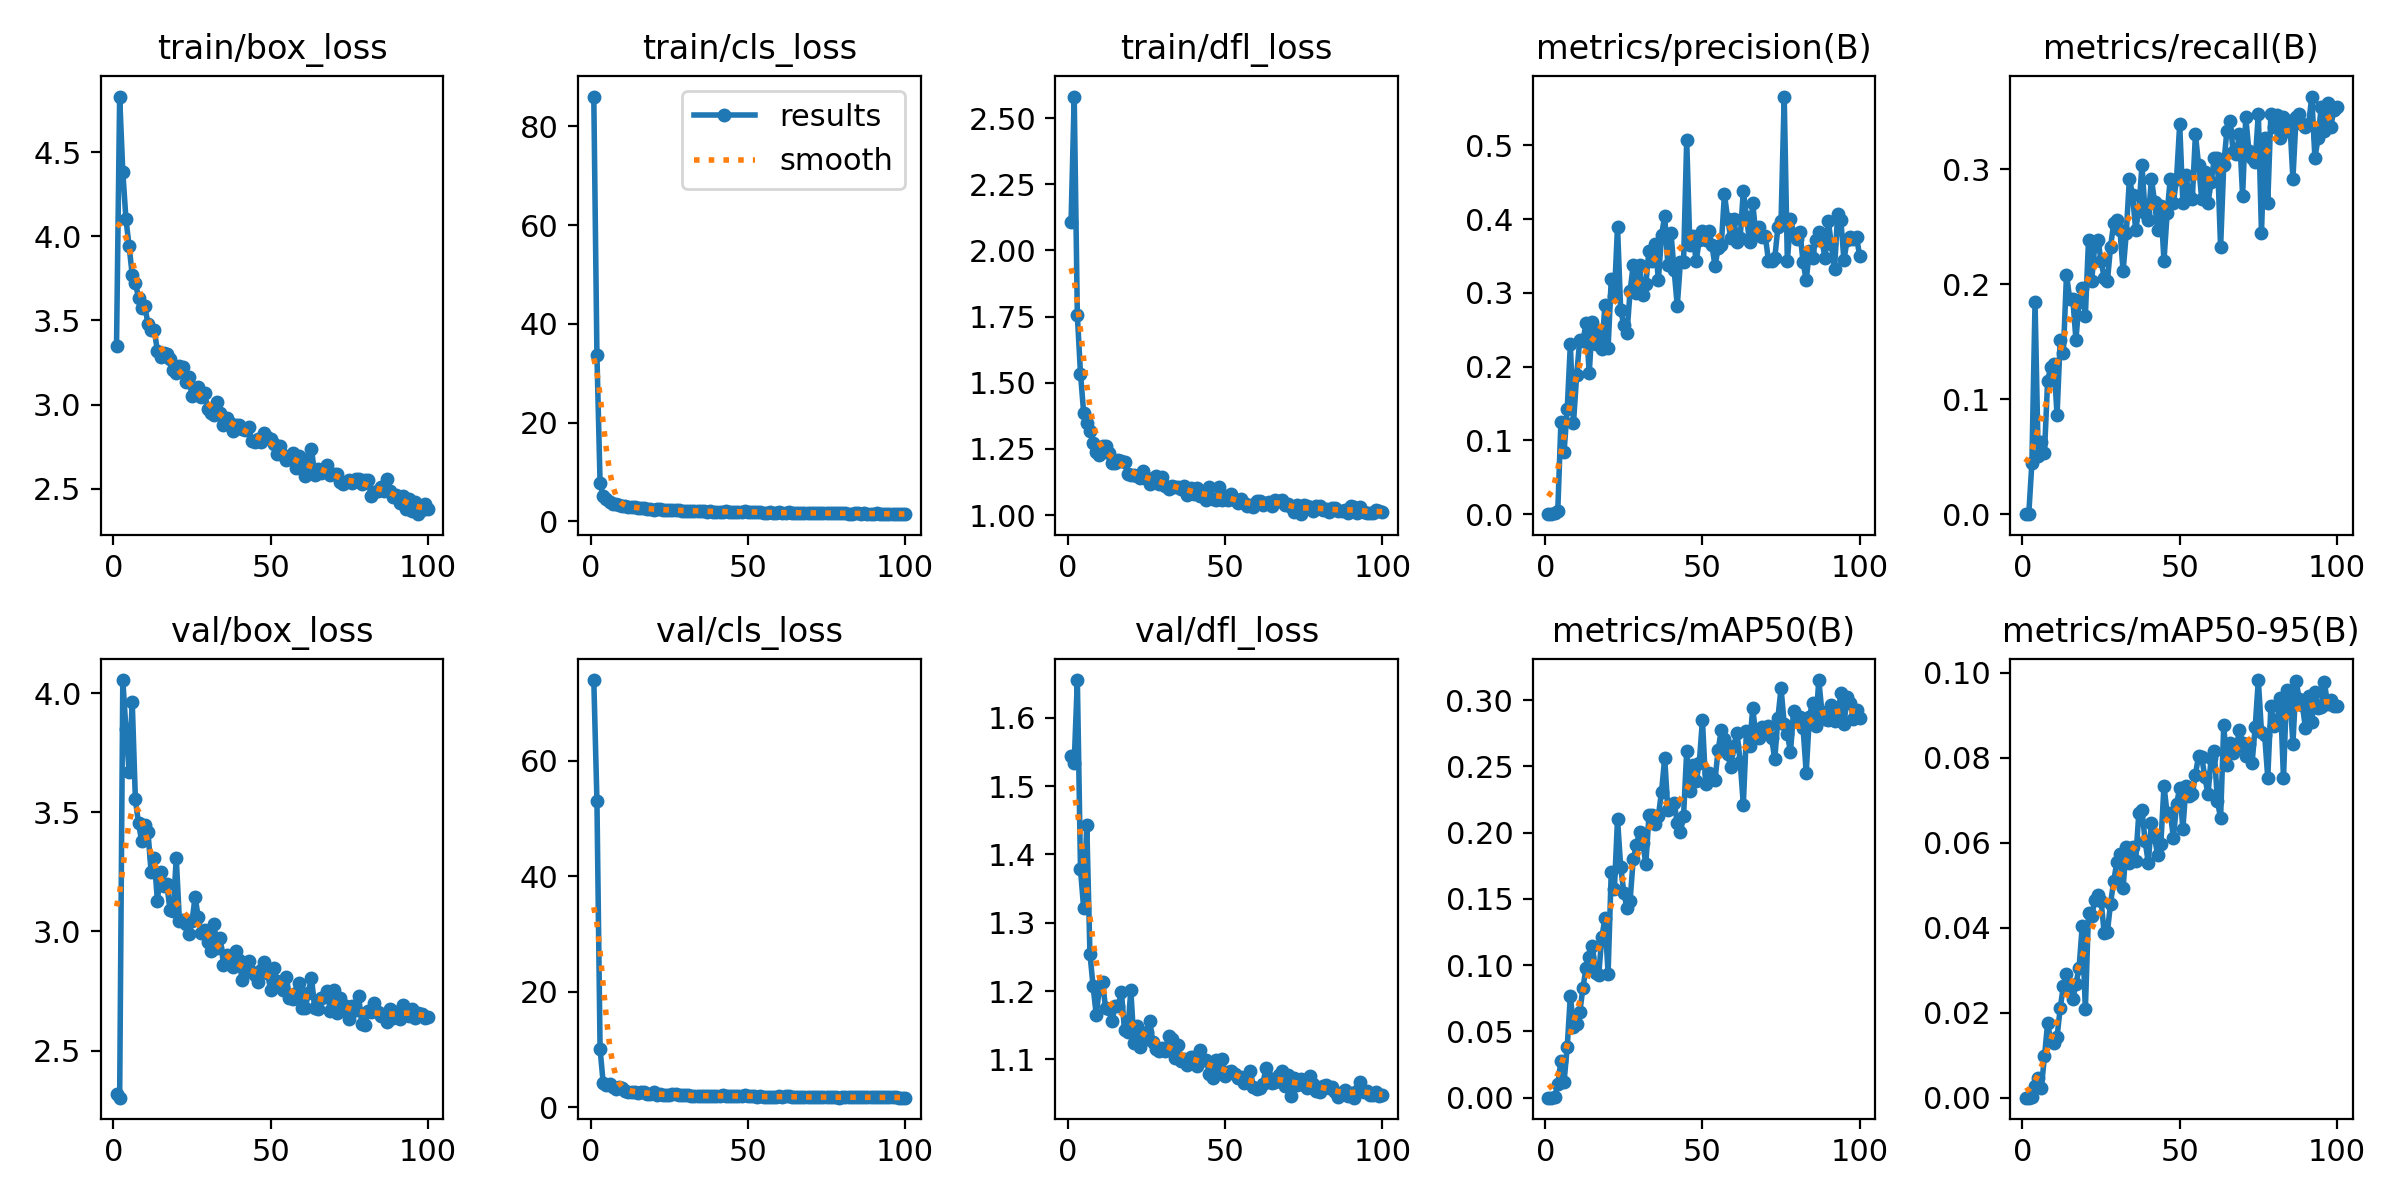

In [51]:
display.Image('stats/model-1/results.png')

Couple of example predictions

In [44]:
import cv2
from ultralytics import YOLO
imgs = []
model = YOLO('models/mod_v1.pt')
for img in tqdm(os.listdir( 'example test/original')):
    img_path = os.path.join('example test/original', img)
    imgs.append(img_path)

i=1
for img in imgs:
    imgr = cv2.imread(img,1)
    results = model(img)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        cv2.rectangle(imgr, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        cv2.putText(imgr, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)    
    cv2.imwrite('example test/model-1/ex'+str(i)+'mod1.jpg',imgr)
    i+=1

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 14997.51it/s]



image 1/1 C:\Users\these\Desktop\tem\example test\original\ex01.jpg: 384x640 3 traffic_lights, 267.6ms
Speed: 3.0ms preprocess, 267.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex02.jpg: 384x640 4 traffic_lights, 255.9ms
Speed: 3.0ms preprocess, 255.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex03.jpg: 384x640 5 traffic_lights, 246.5ms
Speed: 3.0ms preprocess, 246.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex04.jpg: 384x640 2 traffic_lights, 230.2ms
Speed: 4.0ms preprocess, 230.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex05.jpg: 384x640 7 traffic_lights, 244.9ms
Speed: 3.0ms preprocess, 244.9ms inference, 2.4ms postprocess per image at shape (1, 3, 

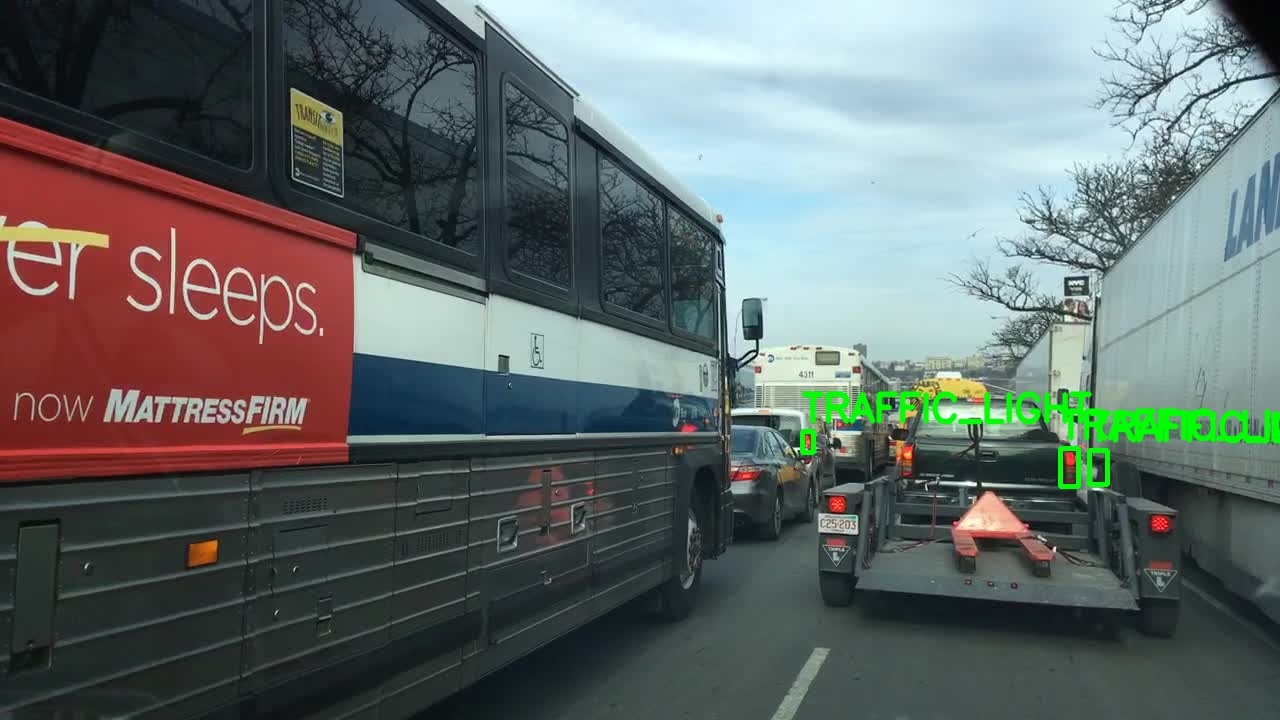

In [45]:
display.Image('example test/model-1/ex1mod1.jpg')

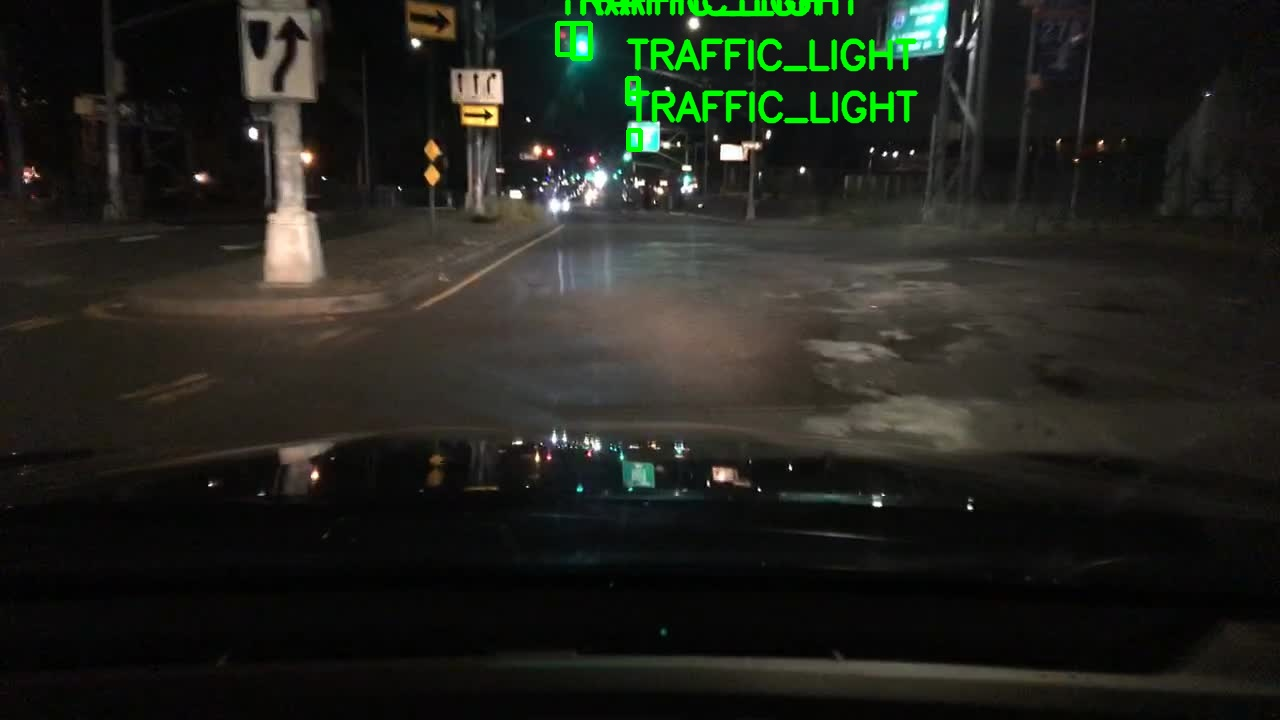

In [48]:
display.Image('example test/model-1/ex2mod1.jpg')

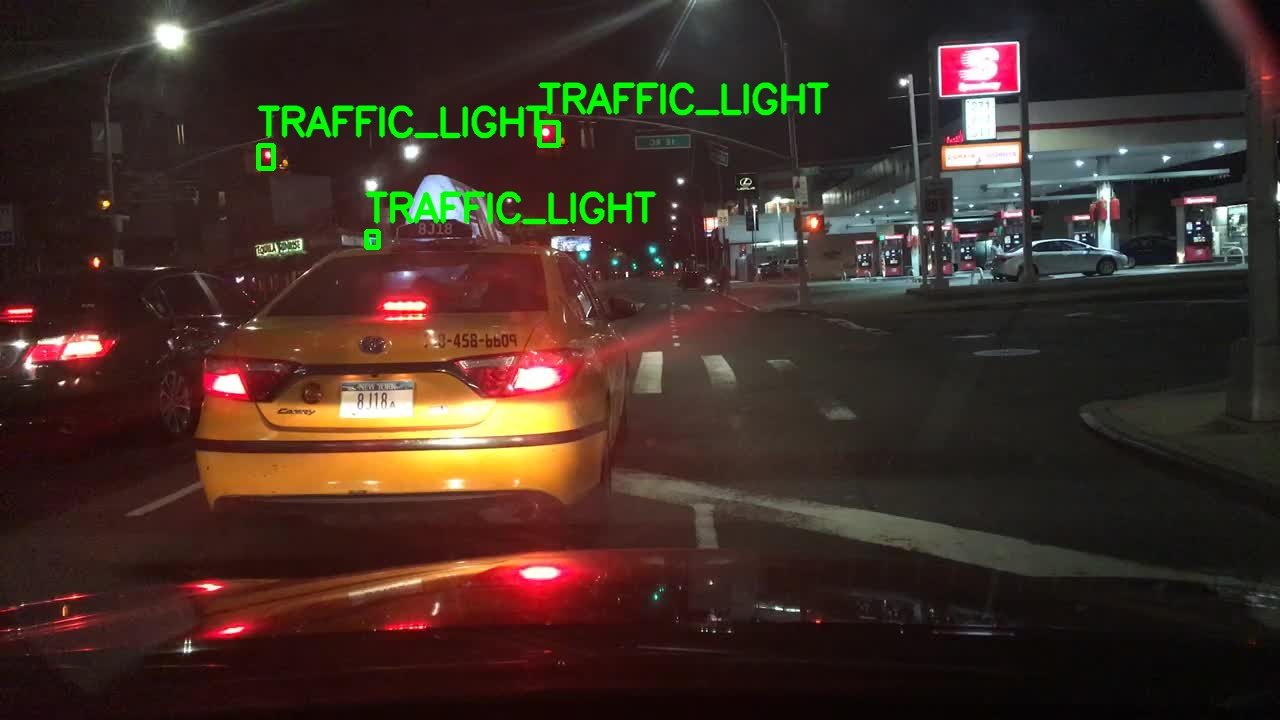

In [49]:
display.Image('example test/model-1/ex9mod1.jpg')

The results of this training are not really good, but this was to be expected since out of 699 images in training set, we had over 200 background photos. Now we are going to readjust the training set to 900 photos with at least one traffic light and 27 background photos.

### First Adjusment

#### Results after the first adjusment - 40 epochs

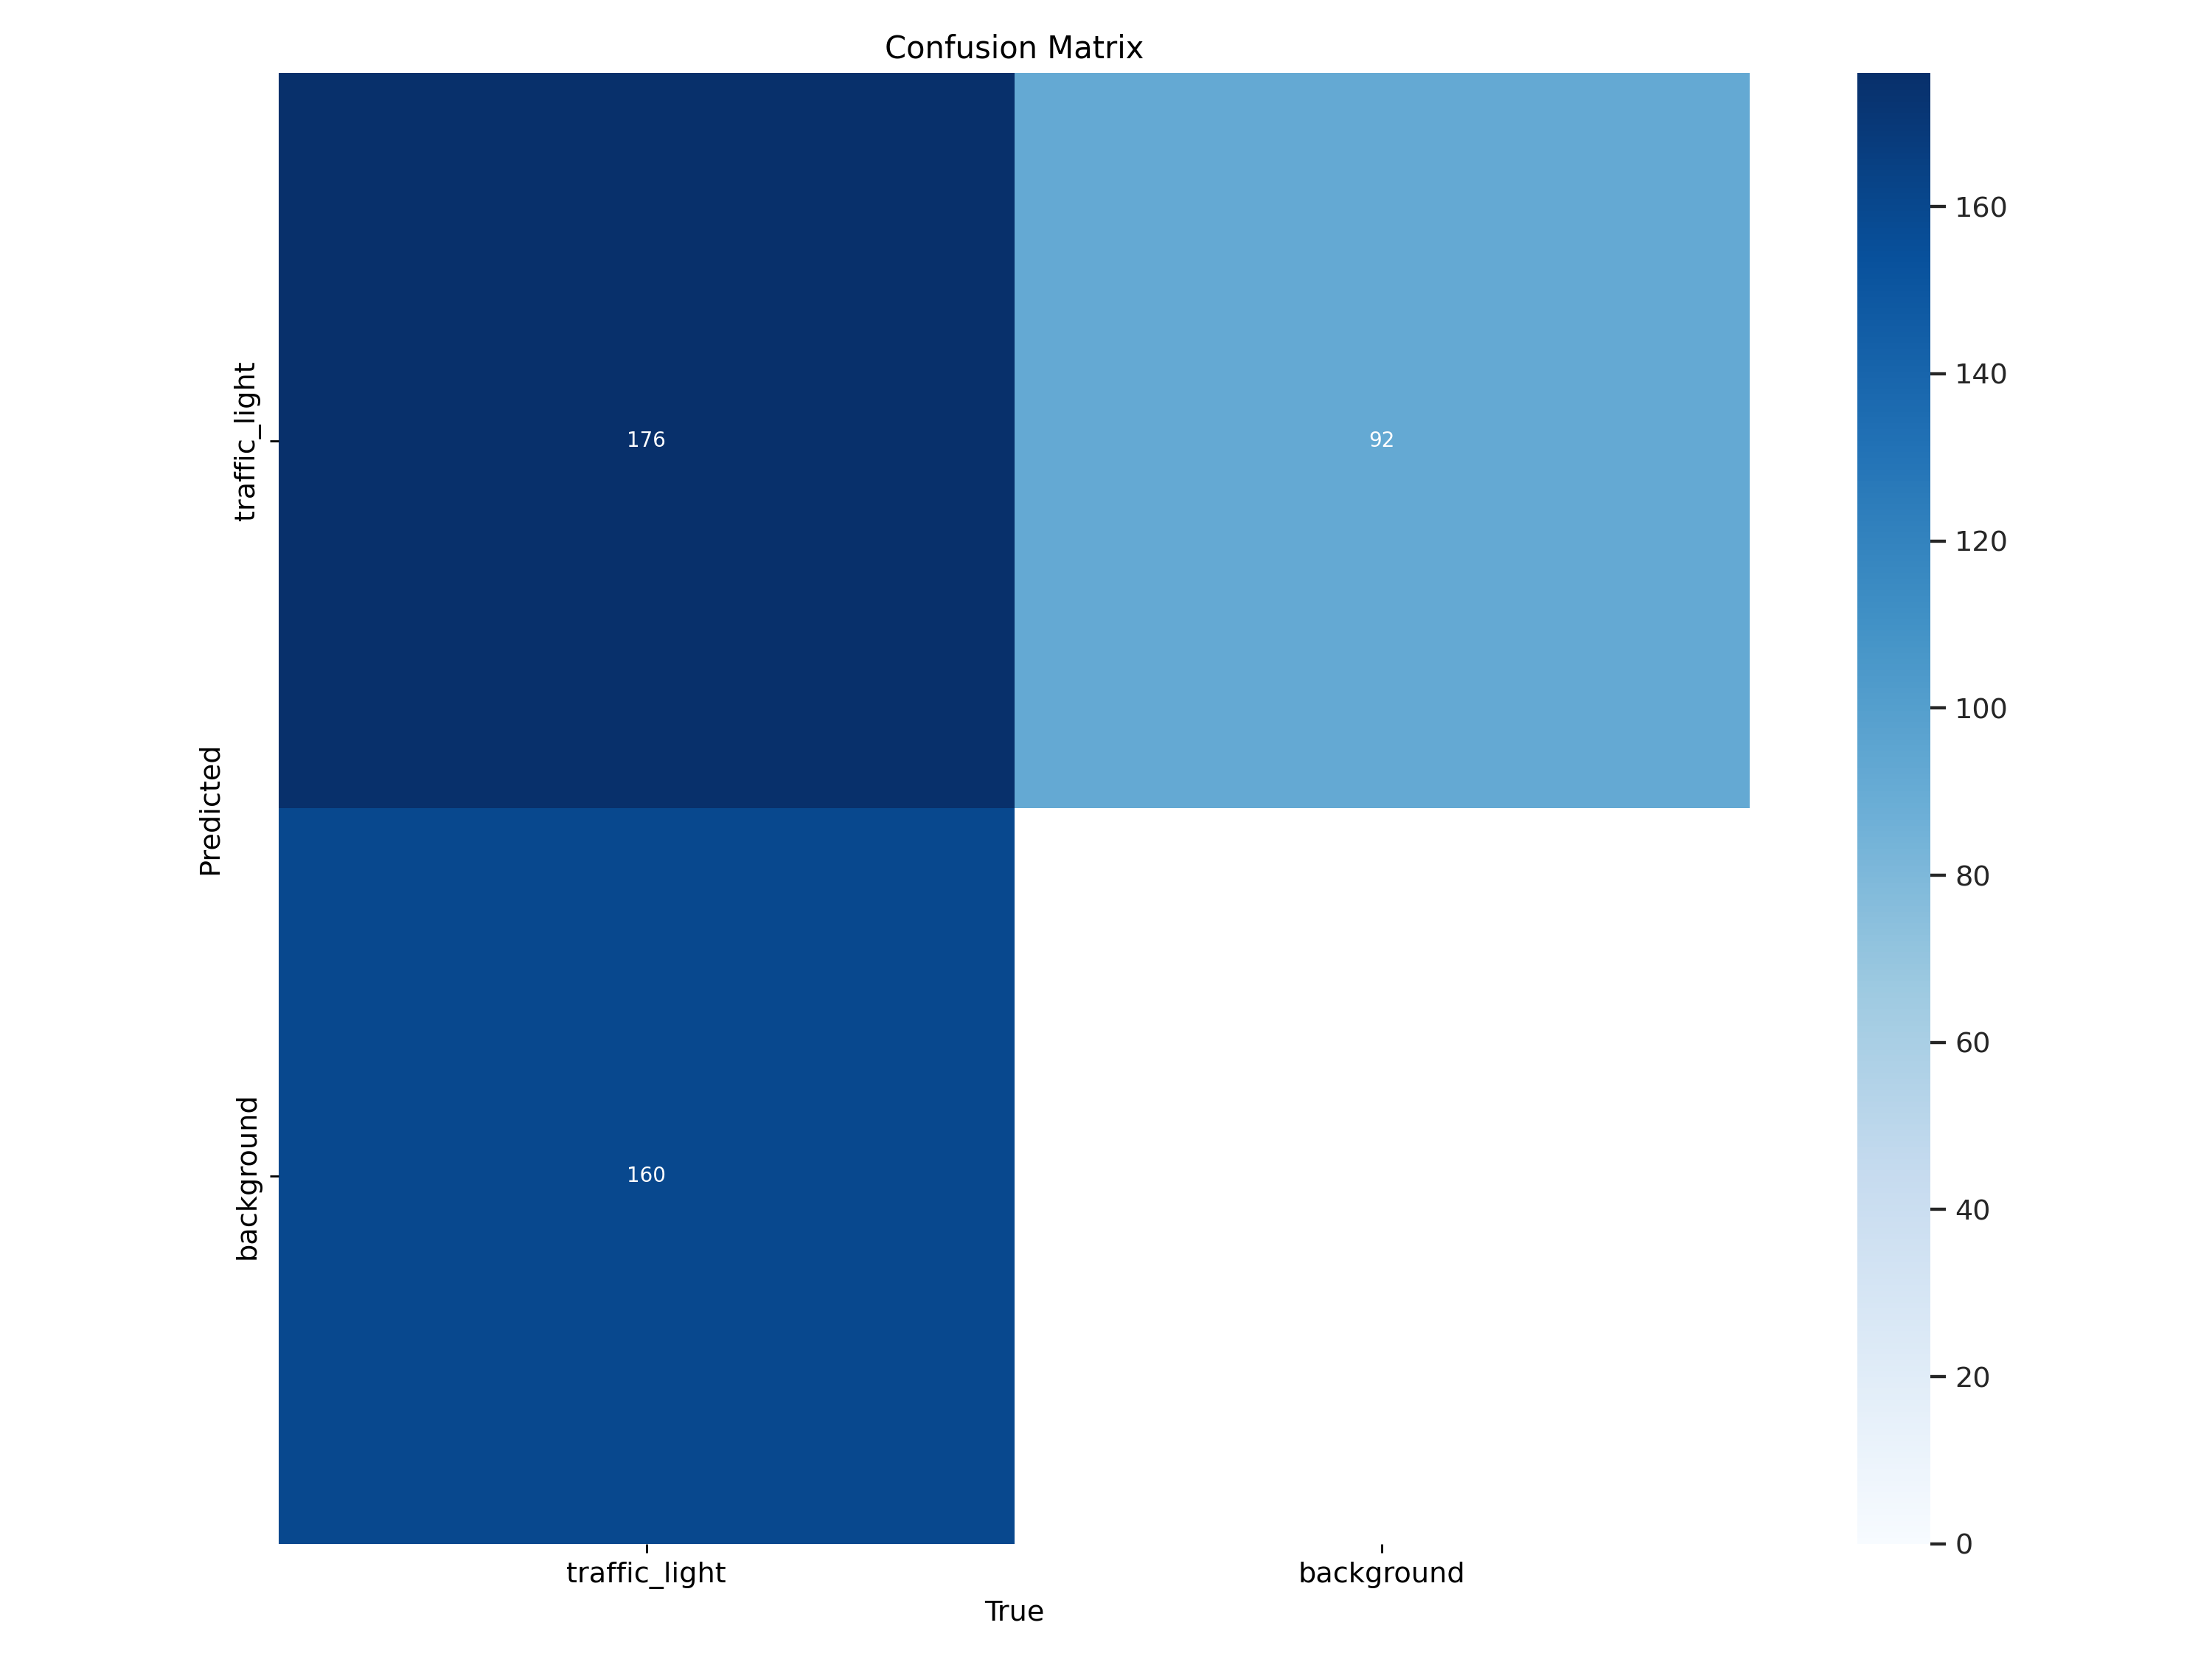

In [52]:
display.Image('stats/model-2/confusion_matrix.png')

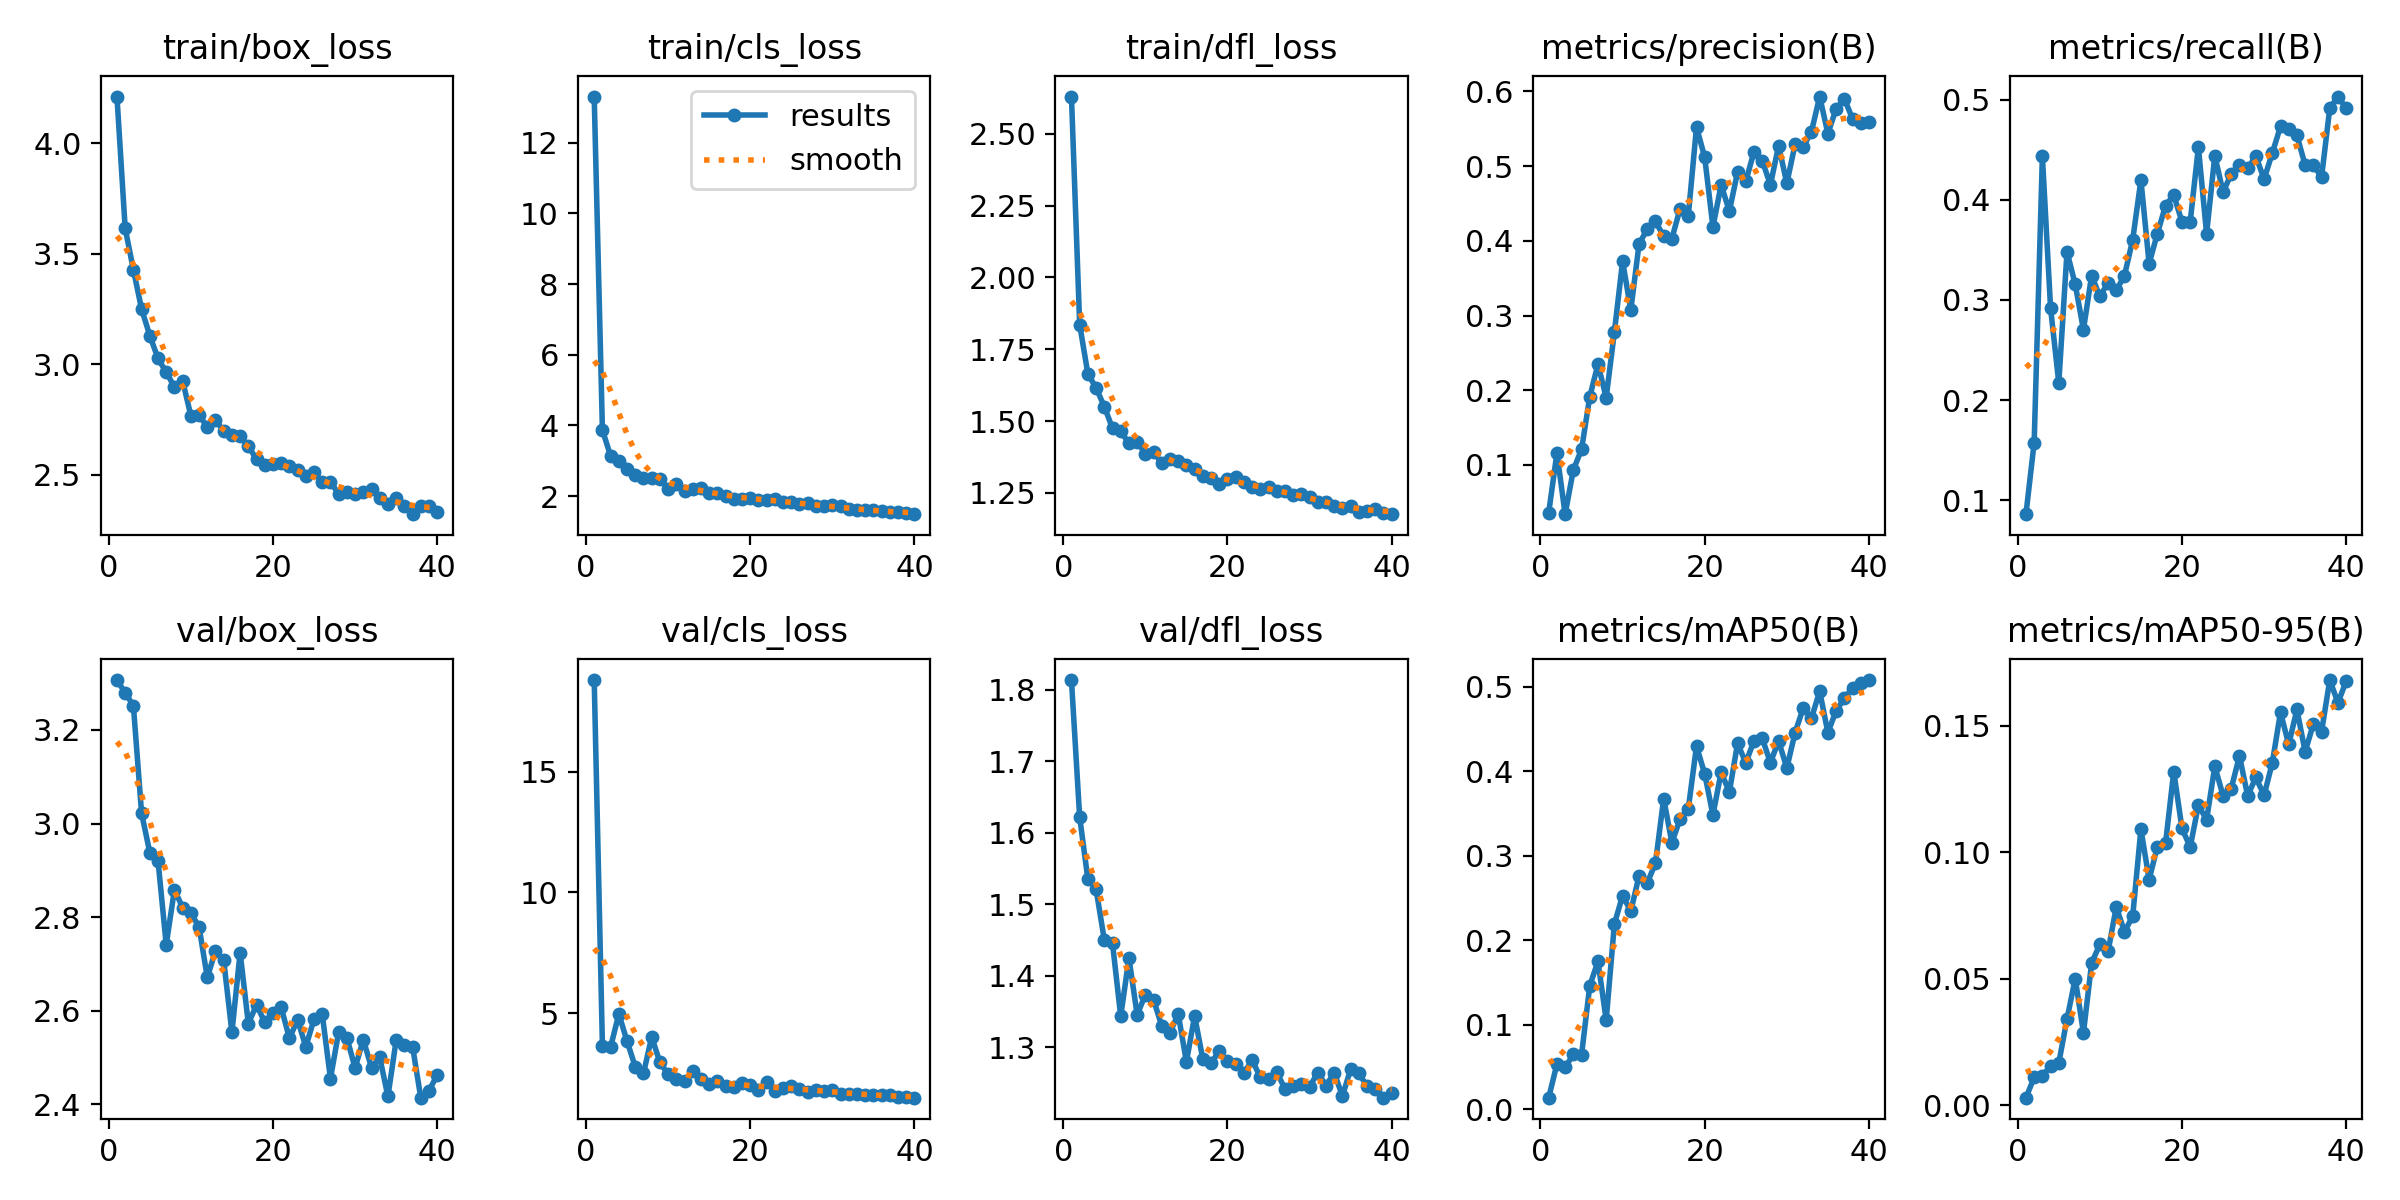

In [53]:
display.Image('stats/model-2/results.png')

In [54]:
imgs = []
model = YOLO('models/mod_v3.pt')
for img in tqdm(os.listdir( 'example test/original')):
    img_path = os.path.join('example test/original', img)
    imgs.append(img_path)

i=1
for img in imgs:
    imgr = cv2.imread(img,1)
    results = model(img)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        cv2.rectangle(imgr, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        cv2.putText(imgr, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)    
    cv2.imwrite('example test/model-2/ex'+str(i)+'mod1.jpg',imgr)
    i+=1

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 14883.97it/s]



image 1/1 C:\Users\these\Desktop\tem\example test\original\ex01.jpg: 736x1280 (no detections), 7100.4ms
Speed: 15.0ms preprocess, 7100.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex02.jpg: 736x1280 3 traffic_lights, 9231.2ms
Speed: 14.0ms preprocess, 9231.2ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex03.jpg: 736x1280 11 traffic_lights, 8880.7ms
Speed: 16.0ms preprocess, 8880.7ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex04.jpg: 736x1280 3 traffic_lights, 8666.7ms
Speed: 12.0ms preprocess, 8666.7ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex05.jpg: 736x1280 11 traffic_lights, 8768.5ms
Speed: 15.0ms preprocess, 8768.5ms inference, 3.0ms postprocess p

If we pay close atention we can see that the ex01 photo has 0 detections (which is correct), in comparison to the first model which has 3 (the first picture shown in the results). 

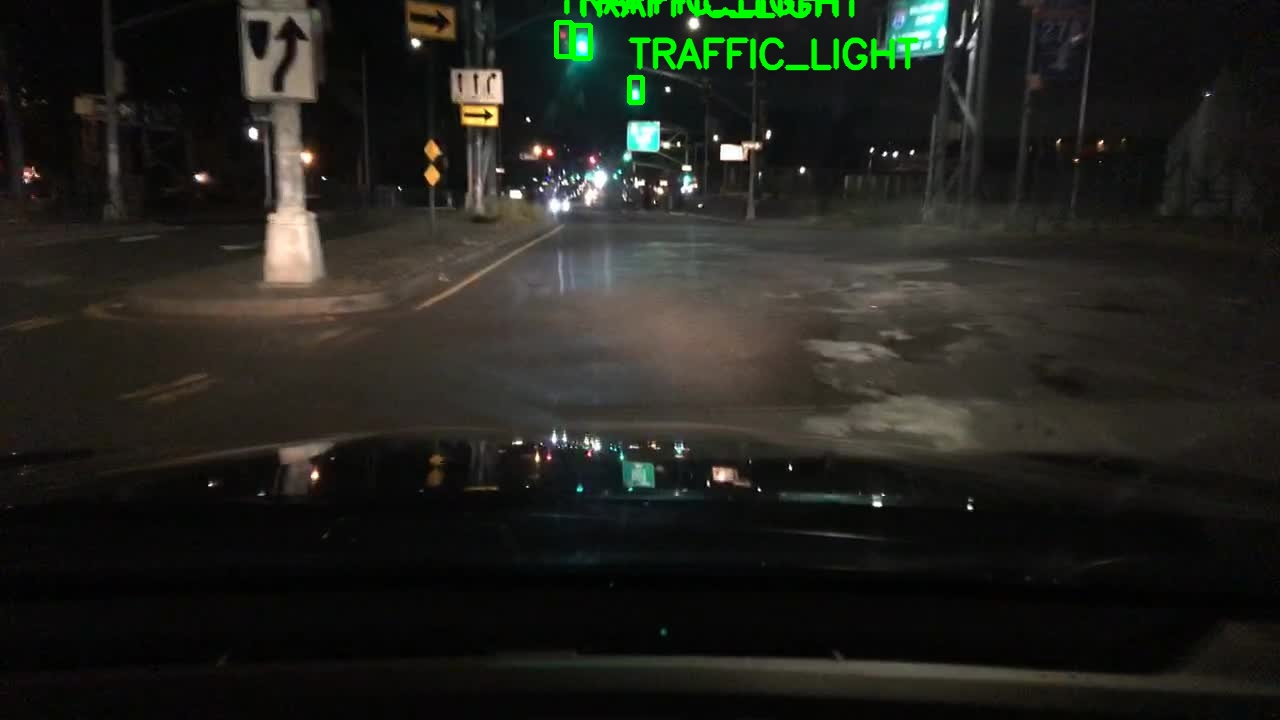

In [59]:
display.Image('example test/model-2/ex2mod1.jpg')

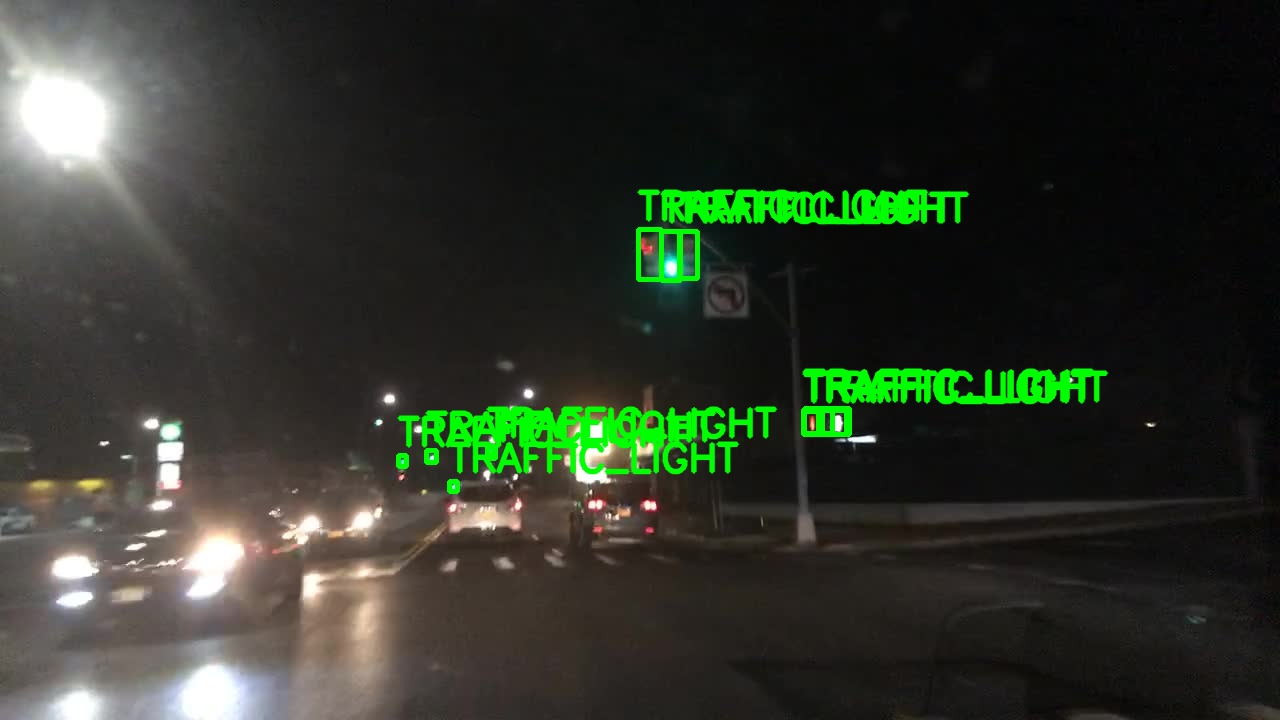

In [56]:
display.Image('example test/model-2/ex3mod1.jpg')

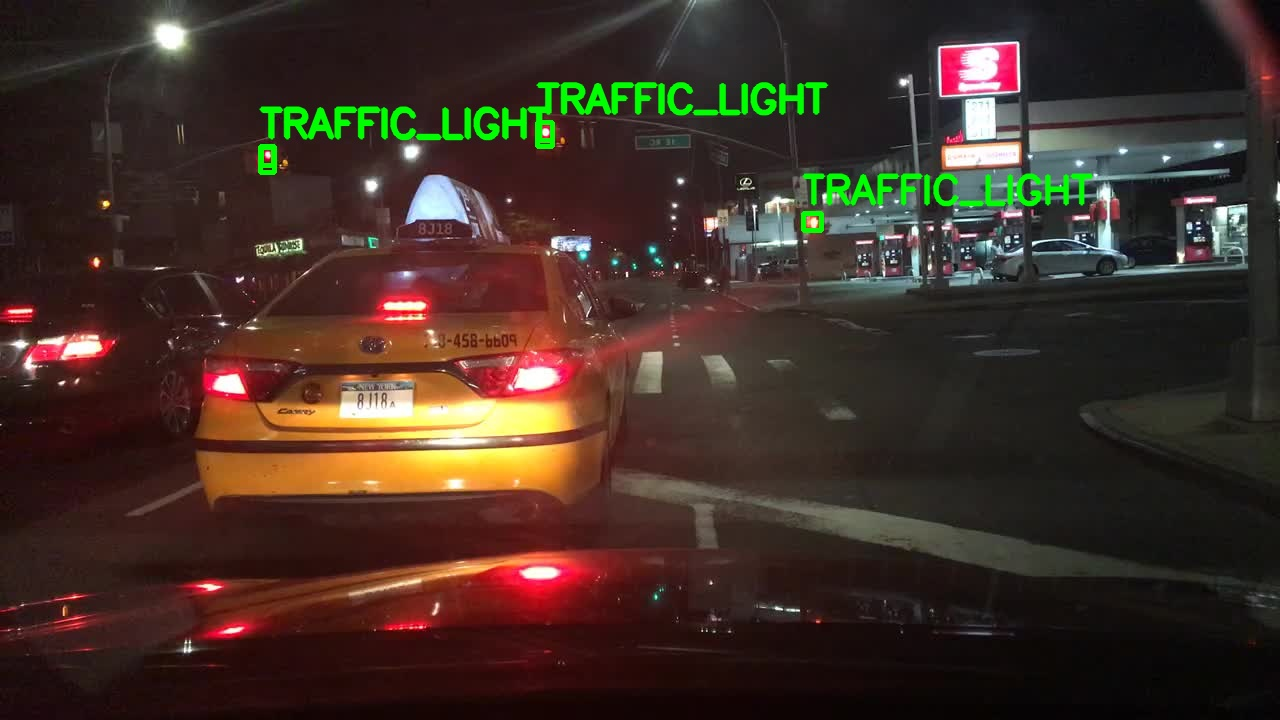

In [57]:
display.Image('example test/model-2/ex9mod1.jpg')

As we can see by the stats and couple of examples, the readjusment did give us an improvement. Now lets see how much more can this model be improved, if we train it on 100 epochs instead of 40.

#### Results after the first adjusment - 100 epochs (not complete)

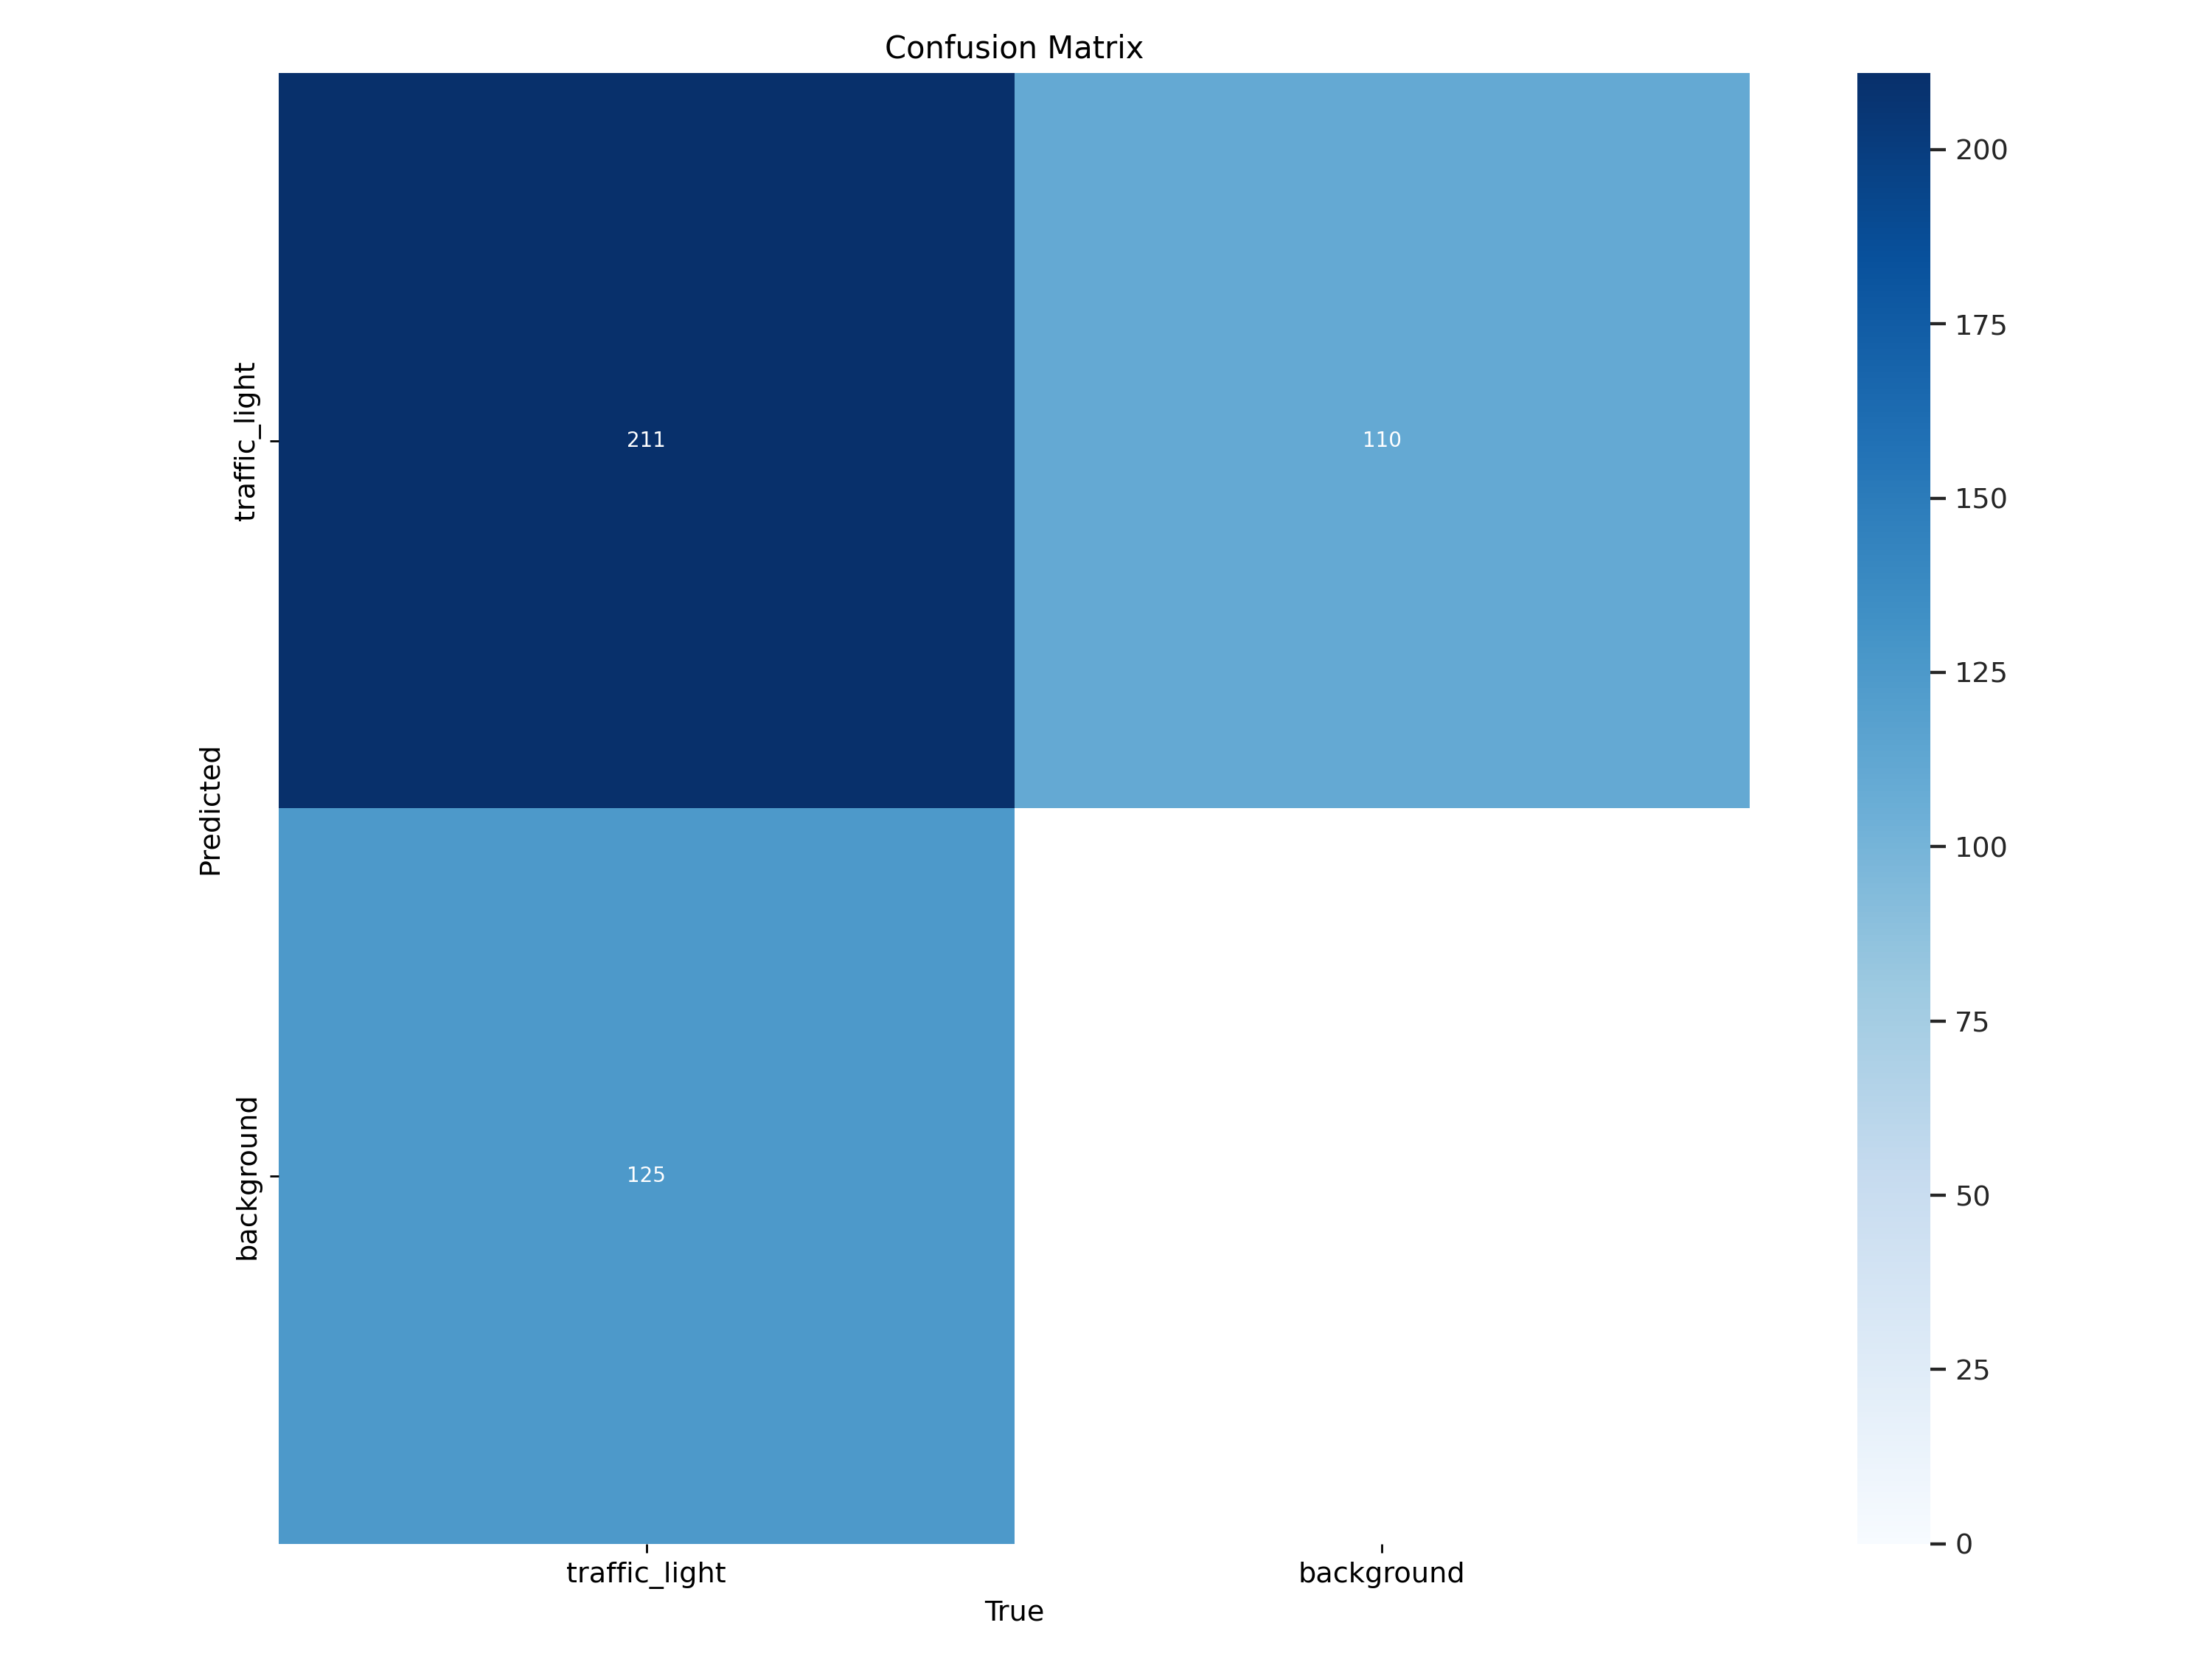

In [2]:
display.Image('stats/model-3/confusion_matrix.png')

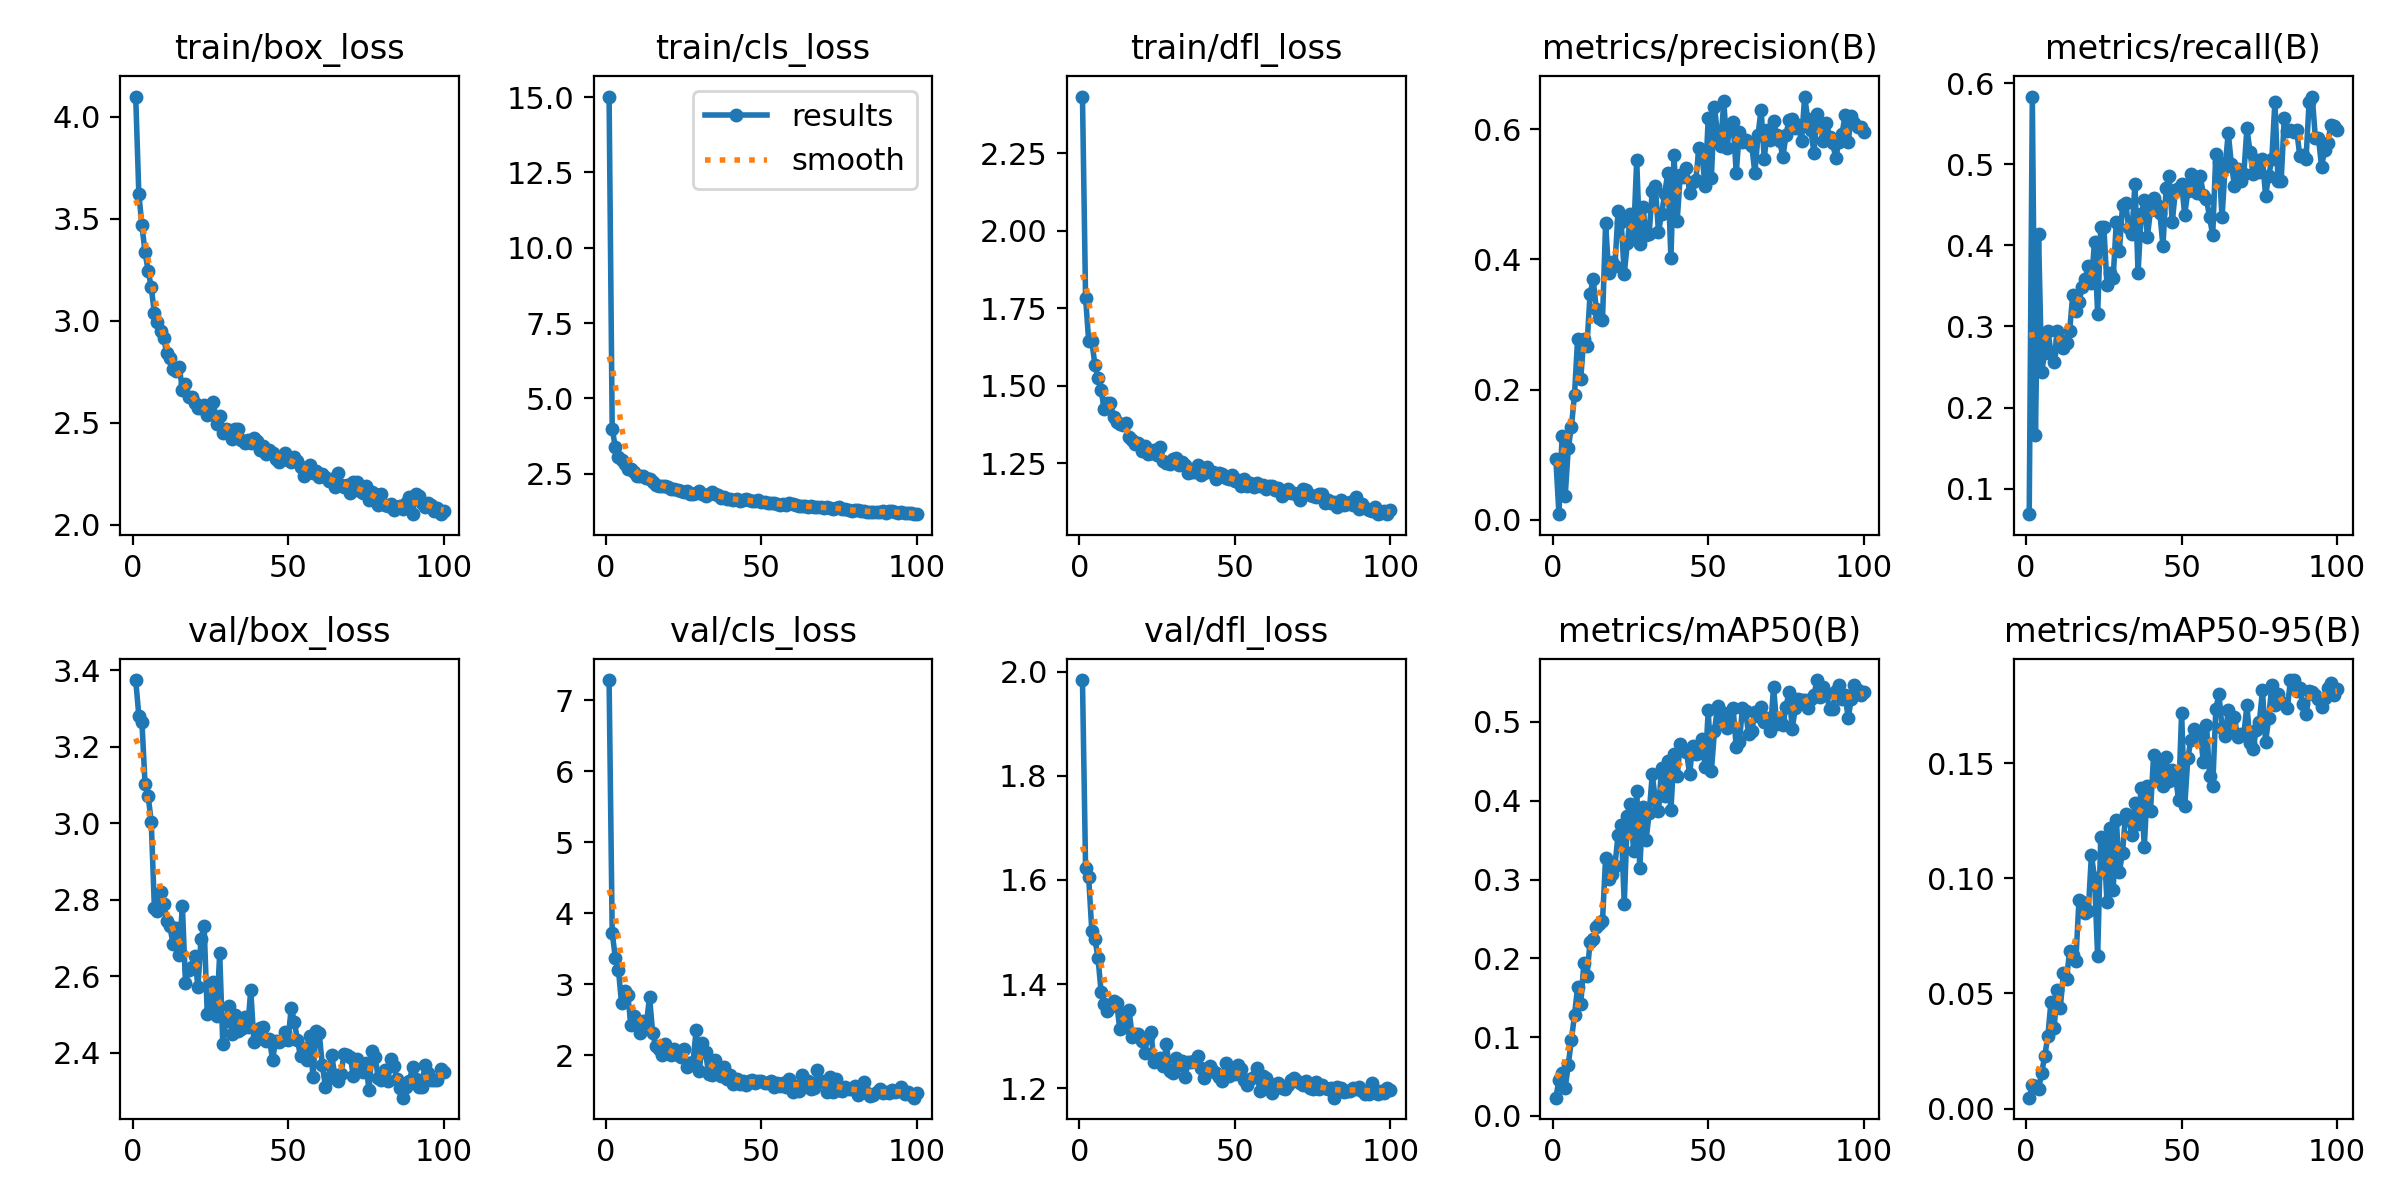

In [4]:
display.Image('stats/model-3/results.png')

In [9]:
import cv2
from ultralytics import YOLO
imgs = []
model = YOLO('models/mod_v4.pt')
for img in tqdm(os.listdir( 'example test/original')):
    img_path = os.path.join('example test/original', img)
    imgs.append(img_path)

i=1
for img in imgs:
    imgr = cv2.imread(img,1)
    results = model(img)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        cv2.rectangle(imgr, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        cv2.putText(imgr, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)    
    cv2.imwrite('example test/model-3/ex'+str(i)+'mod1.jpg',imgr)
    i+=1

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 14958.29it/s]



image 1/1 C:\Users\these\Desktop\tem\example test\original\ex01.jpg: 736x1280 (no detections), 8441.4ms
Speed: 13.3ms preprocess, 8441.4ms inference, 8.1ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex02.jpg: 736x1280 8 traffic_lights, 8498.7ms
Speed: 13.2ms preprocess, 8498.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex03.jpg: 736x1280 9 traffic_lights, 8406.5ms
Speed: 13.0ms preprocess, 8406.5ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex04.jpg: 736x1280 4 traffic_lights, 8410.5ms
Speed: 12.2ms preprocess, 8410.5ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 C:\Users\these\Desktop\tem\example test\original\ex05.jpg: 736x1280 12 traffic_lights, 8301.6ms
Speed: 17.3ms preprocess, 8301.6ms inference, 0.0ms postprocess pe

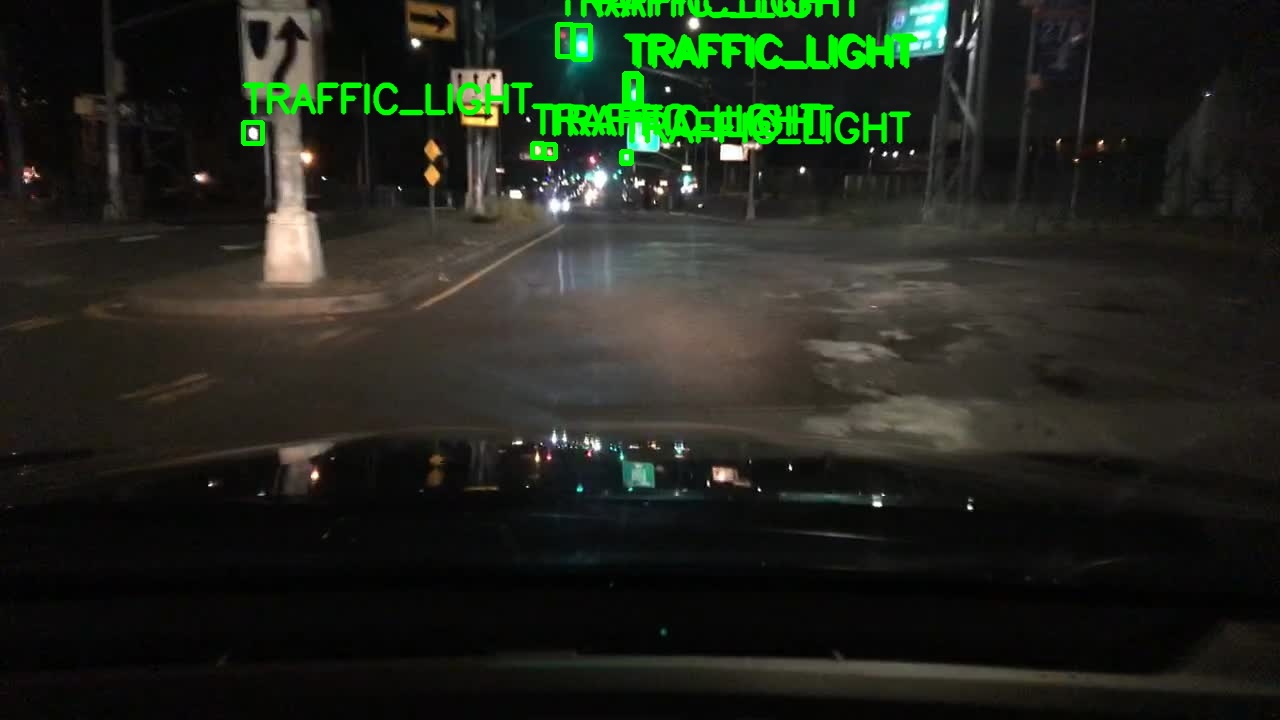

In [10]:
display.Image('example test/model-3/ex2mod1.jpg')

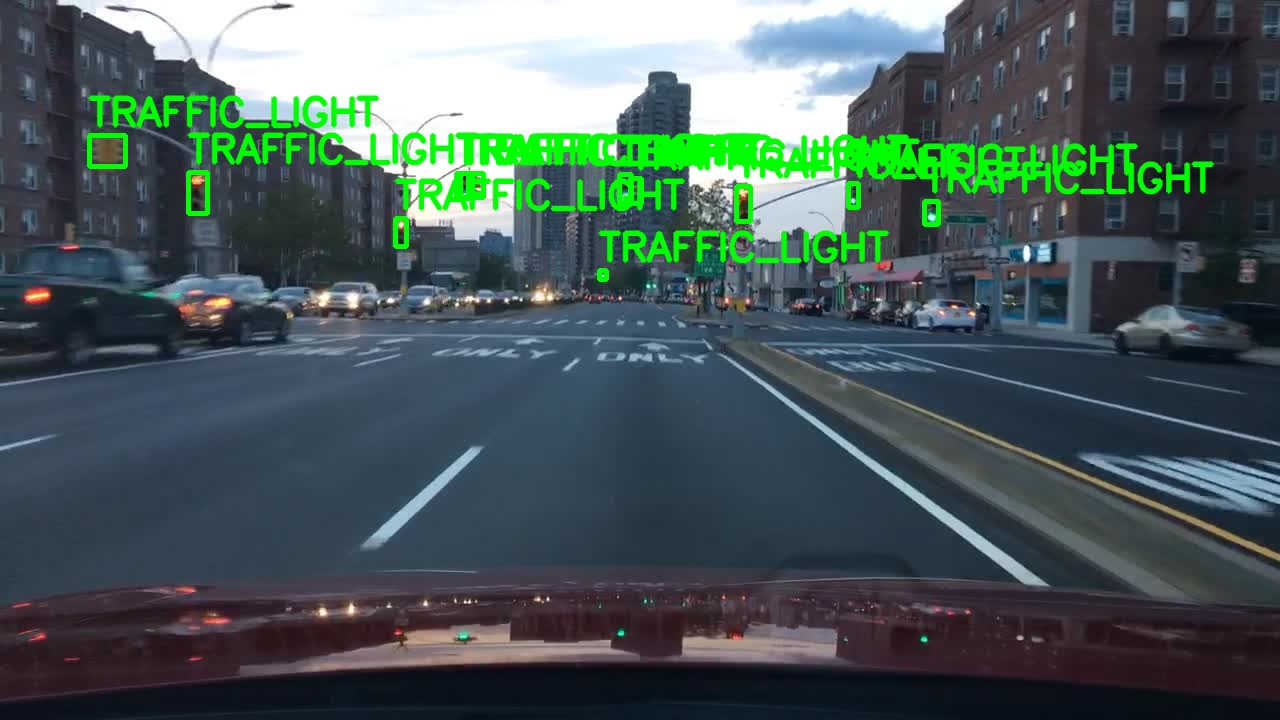

In [11]:
display.Image('example test/model-3/ex5mod1.jpg')

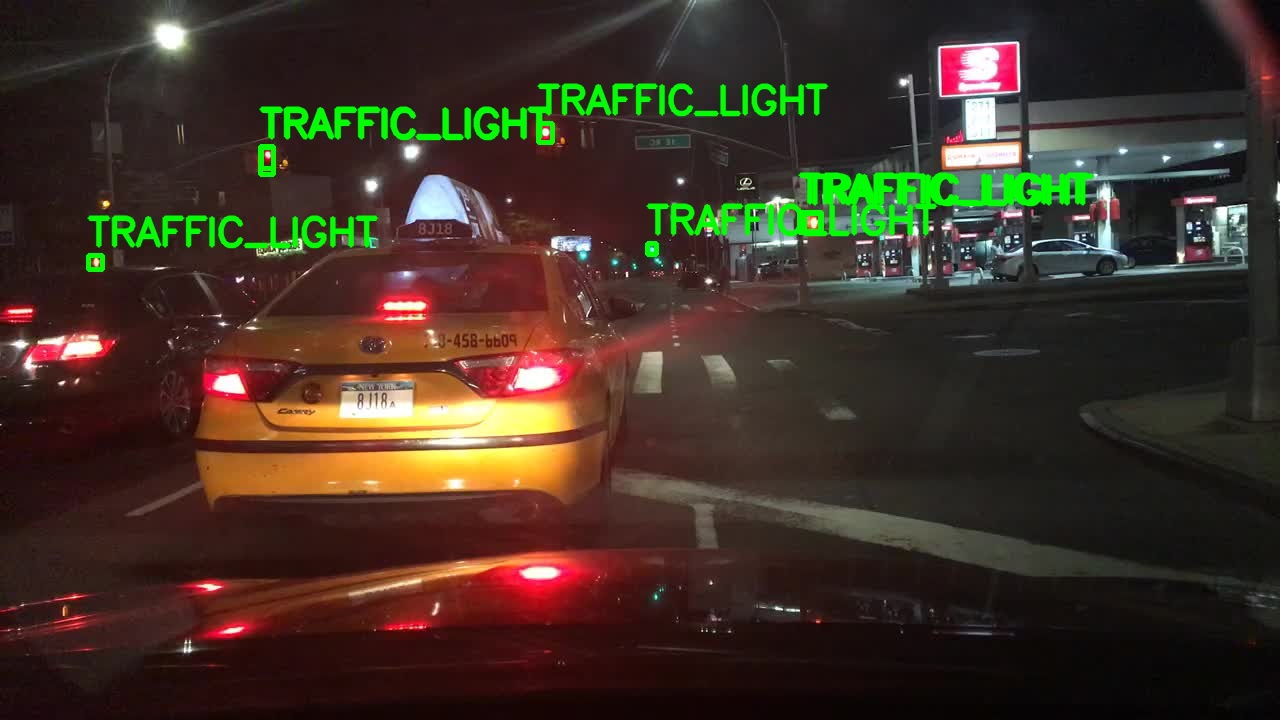

In [12]:
display.Image('example test/model-3/ex9mod1.jpg')

By looking at stats and these examples, we can see that there is a slight improvement in every metric. Most notably we can see that after the 100 epochs of training, the model can see traffic light that are futher away. 

However, there is still a lot of room for improvement. So now, we are not going to use the sample dataset. Instead, we are going to make a sample dataset from the full 100k.

The structure will be something like this:
- Validation to train set ratio will be around 1:7
- There will be around 3600 pictures with traffic lights and 100 without in train set
- Val set is wil have ratio of 7:3 of pictures with and without traffic lights
    
But before we do all this we need to load and analyse the 100k dataset.

### 100k dataset analysis and custom sample creation

In [19]:
train_annotations_path = "bdd100k/train/ann"
train_annotations = load_annotations(train_annotations_path)



df_train_full = pd.DataFrame.from_dict(train_annotations, orient='columns')

val_annotations_path = "bdd100k/val/ann"
val_annotations = load_annotations(val_annotations_path)



df_val_full = pd.DataFrame.from_dict(val_annotations, orient='columns')

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 561.91it/s]


In [20]:
df_train_full

,description,tags,size,objects,filename
0,,"[{'id': 10819788, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89267083, 'classId': 6508807, 'descrip...",0000f77c-6257be58.jpg
1,,"[{'id': 10819797, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89267125, 'classId': 6508804, 'descrip...",0000f77c-62c2a288.jpg
2,,"[{'id': 10819791, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89267095, 'classId': 6508800, 'descrip...",0000f77c-cb820c98.jpg
3,,"[{'id': 10819800, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89267143, 'classId': 6508804, 'descrip...",0001542f-5ce3cf52.jpg
4,,"[{'id': 10819794, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89267108, 'classId': 6508800, 'descrip...",0001542f-7c670be8.jpg
...,...,...,...,...,...
69731,,"[{'id': 11033791, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91648930, 'classId': 6508800, 'descrip...",fe172415-3c36f3d1.jpg
69732,,"[{'id': 11033788, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91648898, 'classId': 6508800, 'descrip...",fe189115-11bedd21.jpg
69733,,"[{'id': 11033785, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91648875, 'classId': 6508807, 'descrip...",fe189115-352995ee.jpg
69734,,"[{'id': 11033794, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91648986, 'classId': 6508807, 'descrip...",fe189115-354e7981.jpg


In [21]:
df_val_full

,description,tags,size,objects,filename
0,,"[{'id': 10789329, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88941475, 'classId': 6508804, 'descrip...",b1c66a42-6f7d68ca.jpg
1,,"[{'id': 10789308, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88941278, 'classId': 6508800, 'descrip...",b1c81faa-3df17267.jpg
2,,"[{'id': 10789311, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88941302, 'classId': 6508804, 'descrip...",b1c81faa-c80764c5.jpg
3,,"[{'id': 10789314, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88941326, 'classId': 6508804, 'descrip...",b1c9c847-3bda4659.jpg
4,,"[{'id': 10789323, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88941406, 'classId': 6508800, 'descrip...",b1ca2e5d-84cf9134.jpg
...,...,...,...,...,...
9995,,"[{'id': 10819772, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89266303, 'classId': 6508800, 'descrip...",fe1d9184-d144106a.jpg
9996,,"[{'id': 10819766, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89266217, 'classId': 6508800, 'descrip...",fe1d9184-dec09b65.jpg
9997,,"[{'id': 10819763, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89266201, 'classId': 6508804, 'descrip...",fe1f2409-5b415eb7.jpg
9998,,"[{'id': 10819775, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89266366, 'classId': 6508804, 'descrip...",fe1f2409-c16ea1ed.jpg


Now lets count how many traffic lights each picture has (in train set).

In [27]:
df_train_full_2 = pd.DataFrame({
    'filename':[],
    'number':[]
})
for i in range(len(df_train_full.index)): 
    file_num_pair={
        'filename':df_train_full.loc[i,'filename'],
        'number':0
    }
    for o in df_train_full.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        if o_id==7:
            file_num_pair['number']+=1
    df_train_full_2.loc[i]=file_num_pair

In [93]:
df_train_full_2=df_train_full_2.sort_values(by='number',ascending=True)
df_train_full_2=df_train_full_2.reset_index()
df_train_full_2=df_train_full_2.drop(columns=['index'])
df_train_full_2

,filename,number
0,58f9d3f8-46e57f9c.jpg,0
1,577bab59-bb201e79.jpg,0
2,5f5911c9-bc91a134.jpg,0
3,5f9b9613-ef3434b7.jpg,0
4,590218a8-1a9b2a5a.jpg,0
...,...,...
69731,7d631db5-8a1cf57e.jpg,21
69732,1b9da180-c518ceae.jpg,21
69733,4710850c-7997700d.jpg,22
69734,3058772e-0fdabd9a.jpg,22


<AxesSubplot: xlabel='number', ylabel='count'>

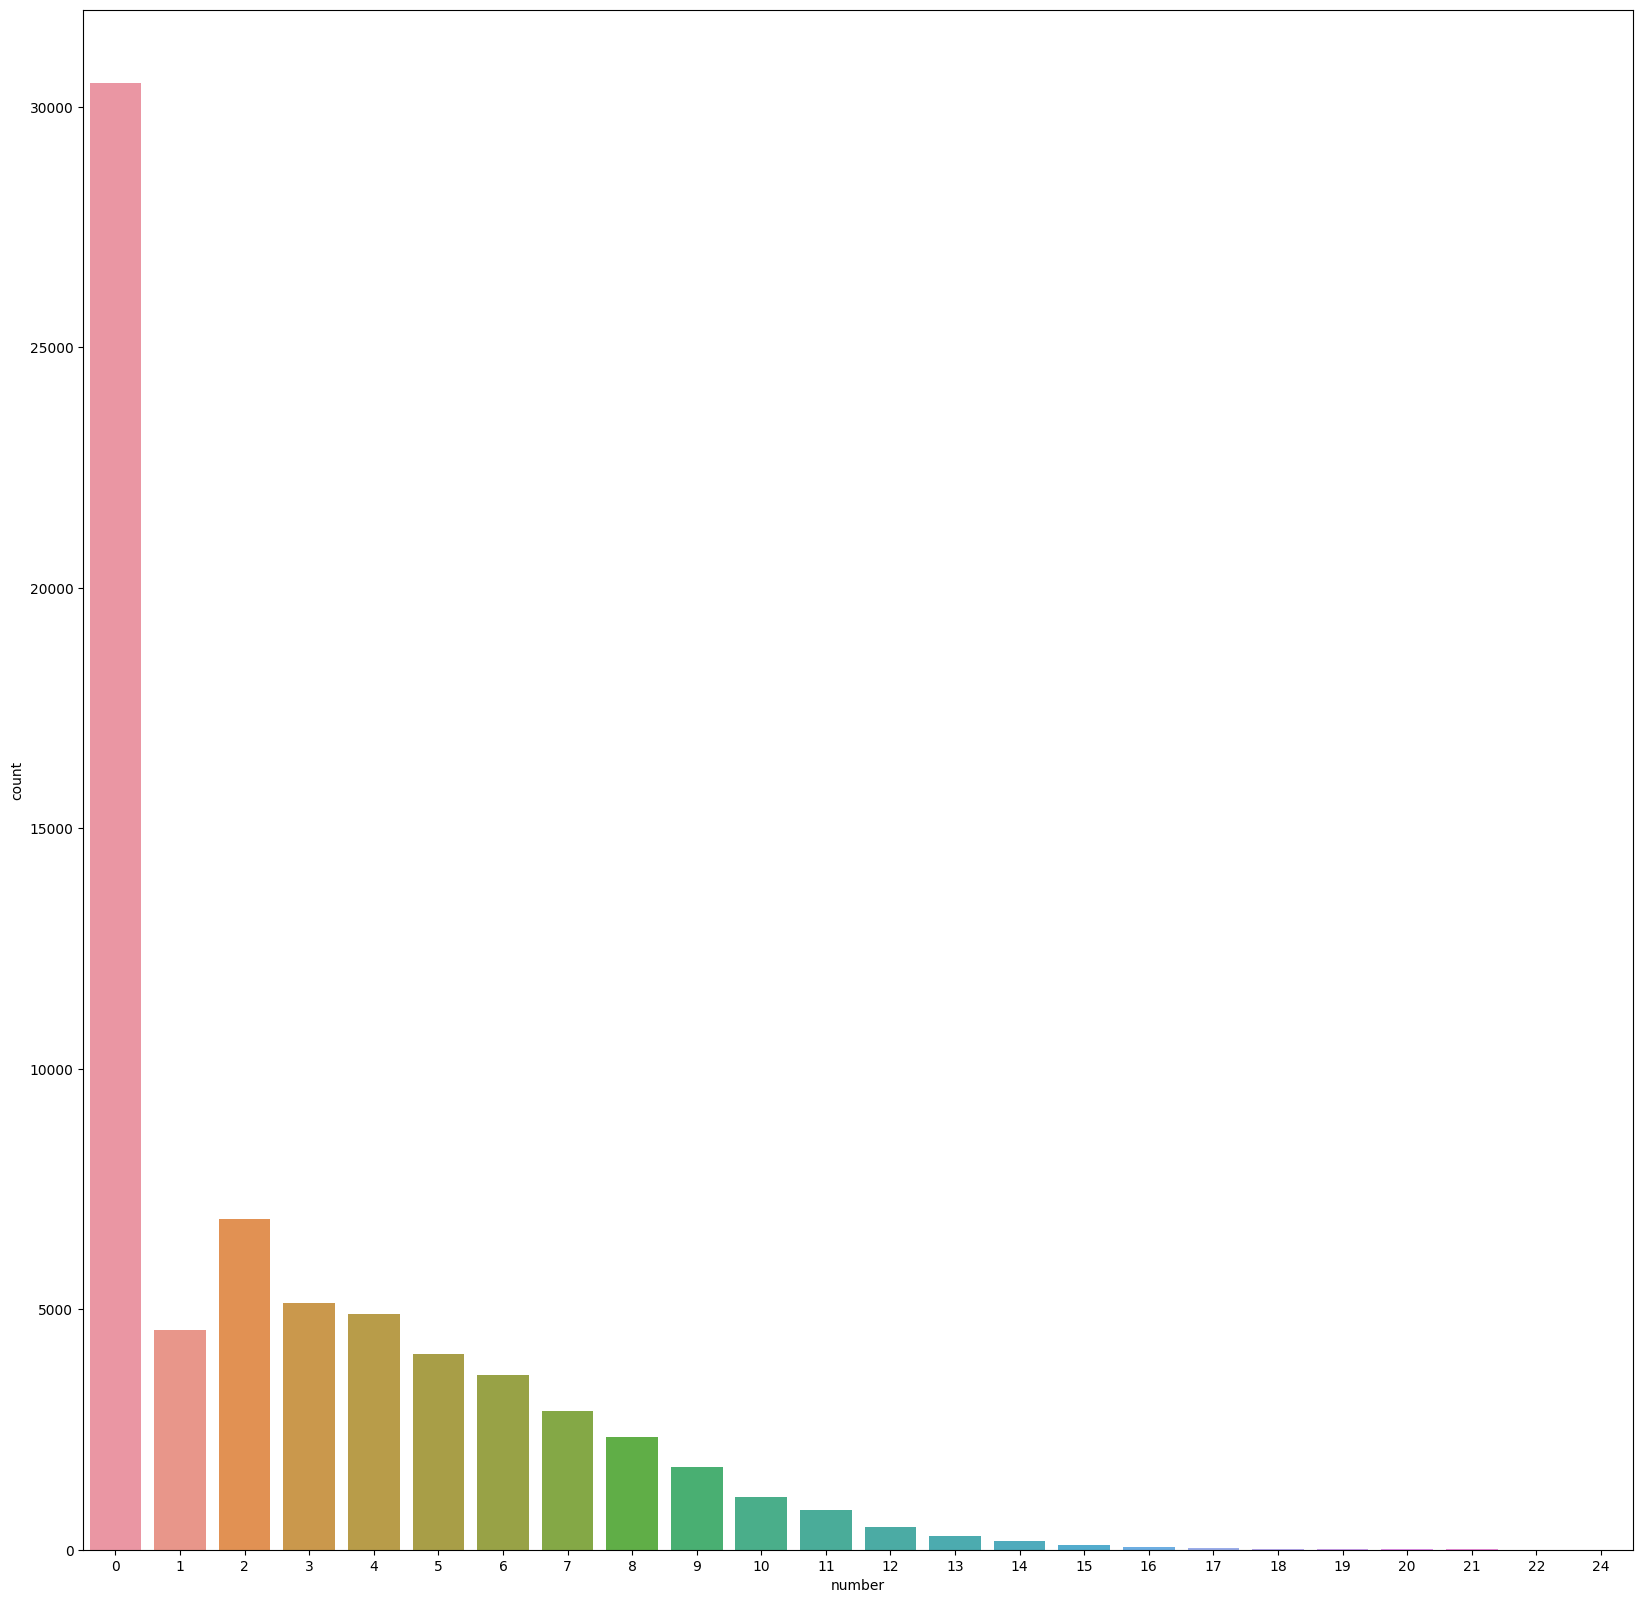

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,1,1)
sns.countplot(x='number',data=df_train_full_2)

For the sample train dataset, we will do the following
- Take 100 photos without traffic lights
- Take 300 photos with 1-10 traffic lights each
- Take 600 photos with most traffic lights

In [94]:
jpg_train_copy = []
cnt=0
current_num=0
i=0
while(i <len(df_train_full_2.index)):
    if current_num==0:
        jpg_train_copy.append(df_train_full_2.loc[i,'filename'])
        cnt+=1
        if cnt==100:
            cnt=0
            current_num+=1
            i=30000
    elif current_num>0 and current_num <11:
        if df_train_full_2.loc[i,'number']==current_num:
            jpg_train_copy.append(df_train_full_2.loc[i,'filename'])
            cnt+=1
            if cnt==300:
                cnt=0
                current_num+=1
    else:
        df_train_full_2=df_train_full_2.sort_values(by='number',ascending=False)
        df_train_full_2=df_train_full_2.reset_index()
        df_train_full_2=df_train_full_2.drop(columns=['index'])
        jpg_train_copy.append(df_train_full_2.loc[cnt,'filename'])
        cnt+=1
        if cnt==600:
            break
    i+=1
           


Now we have names of photos we want to use in train dataset, now lets copy them where we can use them.

In [99]:
import shutil

for jpg in jpg_train_copy:
    shutil.copyfile('bdd100k/train/ann/'+jpg+'.json', 'bdd100kcsam/train/ann/'+jpg+'.json')
    shutil.copyfile('bdd100k/train/images/'+jpg, 'bdd100kcsam/train/images/'+jpg)


Lets look at the validation dataset now.

In [100]:
df_val_full_2 = pd.DataFrame({
    'filename':[],
    'hasTL':[]
})
for i in range(len(df_val_full.index)): 
    file_num_pair={
        'filename':df_val_full.loc[i,'filename'],
        'hasTL':False
    }
    for o in df_val_full.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        if o_id==7:
            file_num_pair['hasTL']=True
            break
    df_val_full_2.loc[i]=file_num_pair

In [101]:
df_val_full_2

,filename,hasTL
0,b1c66a42-6f7d68ca.jpg,True
1,b1c81faa-3df17267.jpg,True
2,b1c81faa-c80764c5.jpg,False
3,b1c9c847-3bda4659.jpg,False
4,b1ca2e5d-84cf9134.jpg,True
...,...,...
9995,fe1d9184-d144106a.jpg,False
9996,fe1d9184-dec09b65.jpg,True
9997,fe1f2409-5b415eb7.jpg,False
9998,fe1f2409-c16ea1ed.jpg,True


For the val set we are gonnna take 350 photos with traffic lights and 150 without (500 total)

In [104]:
true_cnt=350
false_cnt=150
for i in range(len(df_val_full_2.index)):
    if true_cnt==0 and false_cnt==0:
        break
    elif true_cnt==0 and df_val_full_2.loc[i,'hasTL']:
        continue
    elif false_cnt==0 and not df_val_full_2.loc[i,'hasTL']:
        continue
    jpg = df_val_full_2.loc[i,'filename']
    shutil.copyfile('bdd100k/val/ann/'+jpg+'.json', 'bdd100kcsam/val/ann/'+jpg+'.json')
    shutil.copyfile('bdd100k/val/images/'+jpg, 'bdd100kcsam/val/images/'+jpg)
    if df_val_full_2.loc[i,'hasTL']:
        true_cnt-=1
    else:
        false_cnt-=1


After genrating train and val sets, now we need to generate labels for YOLO format.

In [105]:
train_annotations_path = "bdd100kcsam/train/ann"
train_annotations = load_annotations(train_annotations_path)



df_train = pd.DataFrame.from_dict(train_annotations, orient='columns')

val_annotations_path = "bdd100kcsam/val/ann"
val_annotations = load_annotations(val_annotations_path)



df_val = pd.DataFrame.from_dict(val_annotations, orient='columns')

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 786.95it/s]


In [106]:
for i in range(len(df_train.index)):
    save_location = "bdd100kcsam/train/labels/" + df_train.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df_train.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()

In [107]:
for i in range(len(df_val.index)):
    save_location = "bdd100kcsam/val/labels/" + df_val.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df_val.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()

Now we have generated our custom sample dataset that we can use for training. The last thing we need to do is to train the model and review the results. This will be done in twice like the last time (40 and 100 epochs).

### Results after the 2nd adjusment

#### 40 epochs

#### 100 epochs